# Baseline linear model based on anatomy features


Ramp submissions:
- lr_f23_fmri_nv=0.998

In [1]:
path = ".."

import sys
sys.path.insert(0, path)

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

In [7]:
from problem import get_train_data, get_test_data

data_train_, labels_train_ = get_train_data(path=path)
data_test_, labels_test_ = get_test_data(path=path)

data_train = pd.concat([data_train_, pd.Series(labels_train_, index=data_train_.index, name='target')], axis=1)
data_test = pd.concat([data_test_, pd.Series(labels_test_, index=data_test_.index, name='target')], axis=1)
data = pd.concat([data_train, data_test], axis=0)

In [4]:
import os
import re 

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

from nilearn.signal import clean
from nilearn.connectome import ConnectivityMeasure



# Final features selection: 1683
anatomy_fmri_columns = ["anatomy_Brain-Stem / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "anatomy_Brain-Stem / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "anatomy_Brain-Stem / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "anatomy_Brain-Stem / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_BrainSegVol / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "anatomy_BrainSegVol / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "anatomy_MaskVol / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_BrainSegVolNotVent / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "anatomy_BrainSegVolNotVent / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_CSF", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x participants_age", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_sex", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / participants_sex", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_SubCortGrayVol", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x participants_sex", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_sex", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_age", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "anatomy_3rd-Ventricle / anatomy_CC_Mid_Posterior", "anatomy_3rd-Ventricle / anatomy_MaskVol-to-eTIV", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_3rd-Ventricle x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_3rd-Ventricle / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "anatomy_CSF / anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "anatomy_SubCortGrayVol / anatomy_MaskVol-to-eTIV", "anatomy_SubCortGrayVol / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "anatomy_Brain-Stem / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_Brain-Stem", "anatomy_Brain-Stem / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CC_Central", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_TotalGrayVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_3rd-Ventricle x anatomy_CC_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_SubCortGrayVol x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_SubCortGrayVol x anatomy_CC_Central", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CSF x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x participants_age x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_SupraTentorialVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Brain-Stem", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_Optic-Chiasm", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_Brain-Stem", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_TotalGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_eTIV", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_SupraTentorialVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Central", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SubCortGrayVol", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_SubCortGrayVol x anatomy_Brain-Stem", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CSF", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_Brain-Stem", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "anatomy_CC_Anterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Brain-Stem", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Posterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Central", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "anatomy_Brain-Stem / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_MaskVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Posterior x anatomy_TotalGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior x anatomy_CC_Central", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_Brain-Stem", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_Optic-Chiasm", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_CC_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_BrainSegVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_MaskVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_BrainSegVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Mid_Anterior x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Brain-Stem", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CSF", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_MaskVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CSF", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CSF", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_eTIV", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_eTIV", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Central", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_SubCortGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / participants_age x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_Brain-Stem", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Optic-Chiasm", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CSF x anatomy_Brain-Stem", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Brain-Stem", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_4th-Ventricle", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_SubCortGrayVol x anatomy_CSF", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / anatomy_CSF x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "anatomy_CSF / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "anatomy_CC_Anterior / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "anatomy_CC_Anterior / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "anatomy_CC_Anterior / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_4th-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_MaskVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Anterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_MaskVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SupraTentorialVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / participants_age x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_MaskVol", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CSF", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex x anatomy_Brain-Stem", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex x anatomy_Brain-Stem", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex x anatomy_Optic-Chiasm", "power_64 / participants_age", "power_166 x participants_age", "power_409 x participants_age", "power_561 / participants_age", "power_729 x participants_age", "power_729 / participants_age", "power_737 / participants_age", "power_739 x participants_age", "power_739 / participants_age", "power_1028 / participants_age", "power_1366 / participants_age", "power_2347 / participants_age", "power_2726 x participants_age", "power_2840 x participants_age", "power_2840 / participants_age", "power_2856 x participants_age", "power_2875 / participants_age", "power_2897 / participants_age", "power_2910 x participants_age", "power_2923 x participants_age", "power_2945 x participants_age", "power_2946 / participants_age", "power_2958 x participants_age", "power_2958 / participants_age", "power_2961 / participants_age", "power_2962 x participants_age", "power_3028 / participants_age", "power_3098 / participants_age", "power_3142 / participants_age", "power_3318 / participants_age", "power_3576 / participants_age", "power_3594 / participants_age", "power_3633 / participants_age", "power_3640 / participants_age", "power_3679 / participants_age", "power_3684 / participants_age", "power_3687 / participants_age", "power_3853 x participants_age", "power_3880 x participants_age", "power_3925 x participants_age", "power_3940 / participants_age", "power_4014 x participants_age", "power_4336 / participants_age", "power_4380 x participants_age", "power_4395 / participants_age", "power_4402 / participants_age", "power_4447 x participants_age", "power_4478 / participants_age", "power_4637 / participants_age", "power_4713 / participants_age", "power_4796 / participants_age", "power_4858 / participants_age", "power_4862 / participants_age", "power_4867 / participants_age", "power_5067 / participants_age", "power_5106 / participants_age", "power_5569 / participants_age", "power_5690 x participants_age", "power_5696 x participants_age", "power_5696 / participants_age", "power_5703 x participants_age", "power_5703 / participants_age", "power_5768 / participants_age", "power_5911 / participants_age", "power_5999 / participants_age", "power_6112 x participants_age", "power_6112 / participants_age", "power_6184 x participants_age", "power_6186 / participants_age", "power_6630 / participants_age", "power_6658 / participants_age", "power_6661 x participants_age", "power_6661 / participants_age", "power_6663 / participants_age", "power_6664 x participants_age", "power_6664 / participants_age", "power_6816 / participants_age", "power_6825 / participants_age", "power_6867 / participants_age", "power_6878 x participants_age", "power_6915 / participants_age", "power_7066 x participants_age", "power_7196 / participants_age", "power_7205 / participants_age", "power_7320 x participants_age", "power_7332 x participants_age", "power_7332 / participants_age", "power_7382 / participants_age", "power_7474 x participants_age", "power_7479 x participants_age", "power_7487 x participants_age", "power_7752 x participants_age", "power_7752 / participants_age", "power_7917 / participants_age", "power_7967 / participants_age", "power_7969 / participants_age", "power_7994 / participants_age", "power_8099 / participants_age", "power_8205 / participants_age", "power_8275 / participants_age", "power_8288 / participants_age", "power_8321 / participants_age", "power_8349 / participants_age", "power_8451 x participants_age", "power_8451 / participants_age", "power_8462 / participants_age", "power_8465 x participants_age", "power_8477 x participants_age", "power_8590 / participants_age", "power_8596 x participants_age", "power_8611 / participants_age", "power_8619 / participants_age", "power_8620 / participants_age", "power_8704 / participants_age", "power_9037 x participants_age", "power_9291 x participants_age", "power_9291 / participants_age", "power_9347 / participants_age", "power_9471 / participants_age", "power_9539 / participants_age", "power_9570 x participants_age", "power_9711 / participants_age", "power_10222 / participants_age", "power_10251 / participants_age", "power_10375 / participants_age", "power_10463 / participants_age", "power_10667 x participants_age", "power_11208 x participants_age", "power_11438 x participants_age", "power_11705 / participants_age", "power_11710 / participants_age", "power_11783 / participants_age", "power_11938 / participants_age", "power_12472 / participants_age", "power_12579 x participants_age", "power_12583 x participants_age", "power_12583 / participants_age", "power_12587 / participants_age", "power_12621 x participants_age", "power_12721 / participants_age", "power_12794 x participants_age", "power_12805 x participants_age", "power_13073 x participants_age", "power_13158 x participants_age", "power_13169 x participants_age", "power_13206 / participants_age", "power_13368 / participants_age", "power_13446 / participants_age", "power_13718 / participants_age", "power_13864 / participants_age", "power_14169 / participants_age", "power_14201 / participants_age", "power_14707 / participants_age", "power_14787 x participants_age", "power_14904 / participants_age", "power_15182 / participants_age", "power_15193 / participants_age", "power_15196 / participants_age", "power_15198 / participants_age", "power_15217 / participants_age", "power_15220 / participants_age", "power_15291 x participants_age", "power_15343 / participants_age", "power_15366 / participants_age", "power_15538 / participants_age", "power_15814 x participants_age", "power_16050 x participants_age", "power_16258 / participants_age", "power_16264 / participants_age", "power_16372 / participants_age", "power_16529 x participants_age", "power_16530 / participants_age", "power_16551 / participants_age", "power_16732 x participants_age", "power_16741 / participants_age", "power_16745 / participants_age", "power_16786 x participants_age", "power_16786 / participants_age", "power_16787 x participants_age", "power_16787 / participants_age", "power_16906 / participants_age", "power_16915 x participants_age", "power_16955 / participants_age", "power_17240 x participants_age", "power_17394 x participants_age", "power_17394 / participants_age", "power_17426 / participants_age", "power_17451 / participants_age", "power_17581 x participants_age", "power_17581 / participants_age", "power_17627 / participants_age", "power_17977 x participants_age", "power_17990 x participants_age", "power_17990 / participants_age", "power_18053 x participants_age", "power_18111 x participants_age", "power_18116 x participants_age", "power_18129 / participants_age", "power_18329 x participants_age", "power_18394 / participants_age", "power_18446 / participants_age", "power_18450 / participants_age", "power_18711 x participants_age", "power_18762 / participants_age", "power_18764 / participants_age", "power_18766 / participants_age", "power_18791 / participants_age", "power_19021 / participants_age", "power_19025 / participants_age", "power_19027 / participants_age", "power_19450 / participants_age", "power_19451 x participants_age", "power_19526 / participants_age", "power_19620 x participants_age", "power_19735 x participants_age", "power_19750 x participants_age", "power_19761 x participants_age", "power_19769 x participants_age", "power_19771 x participants_age", "power_20002 / participants_age", "power_20202 / participants_age", "power_20215 / participants_age", "power_20430 / participants_age", "power_20475 / participants_age", "power_20606 / participants_age", "power_20762 / participants_age", "power_20882 / participants_age", "power_21381 / participants_age", "power_21600 x participants_age", "power_21853 x participants_age", "power_21853 / participants_age", "power_21875 x participants_age", "power_21875 / participants_age", "power_21914 x participants_age", "power_21972 / participants_age", "power_22251 / participants_age", "power_22348 / participants_age", "power_22353 x participants_age", "power_22353 / participants_age", "power_22563 / participants_age", "power_22657 x participants_age", "power_22659 / participants_age", "power_22693 x participants_age", "power_22870 / participants_age", "power_22982 x participants_age", "power_23183 / participants_age", "power_23363 / participants_age", "power_23402 / participants_age", "power_23411 x participants_age", "power_23439 x participants_age", "power_23439 / participants_age", "power_23601 / participants_age", "power_23746 / participants_age", "power_23831 x participants_age", "power_24012 / participants_age", "power_24053 / participants_age", "power_24145 / participants_age", "power_24149 / participants_age", "power_24171 / participants_age", "power_24195 / participants_age", "power_24296 / participants_age", "power_24493 / participants_age", "power_24898 / participants_age", "power_24922 / participants_age", "power_25163 / participants_age", "power_25383 / participants_age", "power_25391 / participants_age", "power_25396 x participants_age", "power_25452 / participants_age", "power_25606 / participants_age", "power_25678 / participants_age", "power_25838 / participants_age", "power_26062 x participants_age", "power_26066 x participants_age", "power_26066 / participants_age", "power_26077 x participants_age", "power_26085 x participants_age", "power_26085 / participants_age", "power_26133 / participants_age", "power_26547 x participants_age", "power_26762 / participants_age", "power_26769 / participants_age", "power_26773 x participants_age", "power_26823 / participants_age", "power_26983 / participants_age", "power_27215 / participants_age", "power_27222 / participants_age", "power_27276 x participants_age", "power_27280 x participants_age", "power_27293 x participants_age", "power_27307 x participants_age", "power_27312 x participants_age", "power_27314 x participants_age", "power_27463 x participants_age", "power_27463 / participants_age", "power_27481 / participants_age", "power_27572 x participants_age", "power_27658 / participants_age", "power_27704 x participants_age", "power_27704 / participants_age", "power_27760 / participants_age", "power_27764 / participants_age", "power_27767 / participants_age", "power_27993 / participants_age", "power_27994 x participants_age", "power_28006 / participants_age", "power_28009 / participants_age", "power_28035 / participants_age", "power_28113 / participants_age", "power_28123 / participants_age", "power_28124 / participants_age", "power_28132 / participants_age", "power_28283 / participants_age", "power_28320 / participants_age", "power_28334 x participants_age", "power_28526 / participants_age", "power_28560 x participants_age", "power_28740 / participants_age", "power_28744 x participants_age", "power_28744 / participants_age", "power_28819 / participants_age", "power_29064 / participants_age", "power_29071 / participants_age", "power_29166 / participants_age", "power_29203 / participants_age", "power_29222 / participants_age", "power_29630 / participants_age", "power_29867 / participants_age", "power_29880 / participants_age", "power_29895 / participants_age", "power_29951 x participants_age", "power_29951 / participants_age", "power_30023 x participants_age", "power_30023 / participants_age", "power_30084 x participants_age", "power_30105 x participants_age", "power_30106 x participants_age", "power_30135 x participants_age", "power_30214 x participants_age", "power_30270 x participants_age", "power_30270 / participants_age", "power_30313 x participants_age", "power_30477 x participants_age", "power_30599 x participants_age", "power_30640 / participants_age", "power_30644 x participants_age", "power_30645 / participants_age", "power_30666 x participants_age", "power_30666 / participants_age", "power_30701 / participants_age", "power_30705 / participants_age", "power_30721 x participants_age", "power_30721 / participants_age", "power_30724 x participants_age", "power_30744 / participants_age", "power_30760 / participants_age", "power_30763 / participants_age", "power_30831 / participants_age", "power_30848 x participants_age", "power_30848 / participants_age", "power_30986 / participants_age", "power_31306 / participants_age", "power_31308 x participants_age", "power_31308 / participants_age", "power_31316 / participants_age", "power_31365 x participants_age", "power_31439 / participants_age", "power_31441 / participants_age", "power_31444 / participants_age", "power_31452 x participants_age", "power_31683 x participants_age", "power_31761 x participants_age", "power_31854 x participants_age", "power_31854 / participants_age", "power_31870 / participants_age", "power_31876 x participants_age", "power_32011 x participants_age", "power_32013 / participants_age", "power_32102 / participants_age", "power_32111 / participants_age", "power_32177 / participants_age", "power_32268 / participants_age", "power_32345 / participants_age", "power_32483 x participants_age", "power_32496 / participants_age", "power_32559 / participants_age", "power_32569 x participants_age", "power_32650 x participants_age", "power_32650 / participants_age", "power_32829 / participants_age", "power_32874 x participants_age", "power_32877 x participants_age", "power_32878 x participants_age", "power_33063 x participants_age", "power_33085 / participants_age", "power_33297 / participants_age", "power_33595 / participants_age", "power_33644 / participants_age", "power_33688 x participants_age", "power_33688 / participants_age", "power_33771 / participants_age", "power_33959 / participants_age", "power_34154 / participants_age", "power_34163 / participants_age", "power_34289 x participants_age", "power_34372 / participants_age", "power_34553 x participants_age", "power_34553 / participants_age", "anatomy_Brain-Stem x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "anatomy_Brain-Stem / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "anatomy_Brain-Stem / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "anatomy_Brain-Stem / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "anatomy_Brain-Stem / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_BrainSegVol / (anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "anatomy_BrainSegVolNotVent / (anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CSF", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Mid_Posterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / anatomy_CSF", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "anatomy_3rd-Ventricle x participants_age", "anatomy_3rd-Ventricle / participants_age", "anatomy_CSF / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "anatomy_CSF / participants_age", "anatomy_CC_Mid_Posterior / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_CC_Mid_Anterior / participants_age", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_age", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_sex", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_sex", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_age", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_sex", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / participants_sex", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x participants_age", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / participants_age", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_age", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age", "(anatomy_lhCortexVol + anatomy_rhCortexVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x participants_age", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x participants_age", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_age", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x participants_age", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_age", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_age", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / participants_age", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_sex", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_sex", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_age", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_age", "participants_sex / participants_age", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CSF x anatomy_CC_Mid_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_MaskVol-to-eTIV", "anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_CSF", "anatomy_Brain-Stem / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Brain-Stem", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_Optic-Chiasm", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Anterior x anatomy_CC_Mid_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Anterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_MaskVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / participants_age x anatomy_MaskVol-to-eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_CC_Mid_Posterior x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_CC_Mid_Posterior x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x participants_age x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / participants_age x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / participants_age x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_CSF", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Anterior x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Central", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_age x anatomy_TotalGrayVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Central", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / anatomy_CC_Mid_Anterior x anatomy_TotalGrayVol", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Central", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Central", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CSF", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CSF", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_age x anatomy_Brain-Stem", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_eTIV", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CSF", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CSF", "anatomy_3rd-Ventricle x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "anatomy_CC_Mid_Posterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_3rd-Ventricle", "anatomy_CC_Mid_Posterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Optic-Chiasm", "anatomy_CC_Mid_Posterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_BrainSegVolNotVentSurf", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_SupraTentorialVol", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_SupraTentorialVolNotVent", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_eTIV", "anatomy_CC_Mid_Anterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SubCortGrayVol", "anatomy_CC_Anterior / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Brain-Stem", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Brain-Stem", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Optic-Chiasm", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_eTIV", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "anatomy_Brain-Stem / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CSF", "anatomy_Brain-Stem / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Anterior", "anatomy_Brain-Stem x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_SubCortGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_CC_Central", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_eTIV", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_MaskVol-to-eTIV x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_MaskVol-to-eTIV x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_MaskVol-to-eTIV x anatomy_CC_Central", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_MaskVol-to-eTIV x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_eTIV", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CSF x anatomy_CC_Central", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / participants_age x anatomy_CC_Central", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_CC_Mid_Posterior x anatomy_4th-Ventricle", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_SubCortGrayVol x anatomy_WM-hypointensities", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_CC_Mid_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Anterior", "anatomy_3rd-Ventricle / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "anatomy_CC_Anterior x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CSF", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Central", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_age x anatomy_Brain-Stem", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Central", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age x anatomy_CC_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_eTIV", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Anterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Brain-Stem", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x participants_age x anatomy_CC_Central", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_TotalGrayVol", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_SupraTentorialVol", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_eTIV", "power_12276 / participants_age", "power_283 / participants_age", "power_417 / participants_age", "power_497 / participants_age", "power_541 / participants_age", "power_882 / participants_age", "power_1027 / participants_age", "power_1236 / participants_age", "power_1307 x participants_age", "power_1307 / participants_age", "power_1572 x participants_age", "power_1677 x participants_age", "power_1677 / participants_age", "power_1727 x participants_age", "power_1735 x participants_age", "power_1749 x participants_age", "power_1756 x participants_age", "power_2040 / participants_age", "power_2051 / participants_age", "power_2135 / participants_age", "power_2138 / participants_age", "power_2312 x participants_age", "power_2312 / participants_age", "power_2375 / participants_age", "power_2675 x participants_age", "power_2681 x participants_age", "power_2860 x participants_age", "power_2894 / participants_age", "power_2926 / participants_age", "power_2927 / participants_age", "power_2932 / participants_age", "power_3163 / participants_age", "power_3268 x participants_age", "power_3408 / participants_age", "power_3479 / participants_age", "power_3538 / participants_age", "power_4077 / participants_age", "power_4081 / participants_age", "power_4224 / participants_age", "power_4235 / participants_age", "power_4280 / participants_age", "power_4364 / participants_age", "power_4425 / participants_age", "power_4547 / participants_age", "power_5055 x participants_age", "power_5466 / participants_age", "power_6333 / participants_age", "power_6404 / participants_age", "power_6474 x participants_age", "power_6596 x participants_age", "power_6601 x participants_age", "power_6622 x participants_age", "power_6622 / participants_age", "power_6624 / participants_age", "power_6955 / participants_age", "power_6957 / participants_age", "power_7482 / participants_age", "power_7622 / participants_age", "power_7679 x participants_age", "power_7682 / participants_age", "power_7927 / participants_age", "power_8045 / participants_age", "power_8376 / participants_age", "power_8780 x participants_age", "power_8887 / participants_age", "power_9209 / participants_age", "power_9212 / participants_age", "power_9267 x participants_age", "power_9267 / participants_age", "power_9306 x participants_age", "power_9377 / participants_age", "power_9459 / participants_age", "power_9503 x participants_age", "power_9503 / participants_age", "power_9529 / participants_age", "power_9674 x participants_age", "power_9750 x participants_age", "power_9887 / participants_age", "power_9947 / participants_age", "power_9977 / participants_age", "power_10157 / participants_age", "power_10182 x participants_age", "power_10182 / participants_age", "power_10457 / participants_age", "power_10598 x participants_age", "power_10660 / participants_age", "power_10721 / participants_age", "power_10723 / participants_age", "power_10951 / participants_age", "power_10953 / participants_age", "power_10964 / participants_age", "power_11103 / participants_age", "power_11500 / participants_age", "power_11524 x participants_age", "power_11525 x participants_age", "power_11541 x participants_age", "power_11569 x participants_age", "power_11569 / participants_age", "power_11653 / participants_age", "power_11668 / participants_age", "power_11904 / participants_age", "power_11925 / participants_age", "power_12277 x participants_age", "power_12858 / participants_age", "power_12955 / participants_age", "power_12957 / participants_age", "power_12987 / participants_age", "power_13252 x participants_age", "power_13259 x participants_age", "power_13261 x participants_age", "power_13261 / participants_age", "power_13341 / participants_age", "power_13503 / participants_age", "power_13586 / participants_age", "power_13610 / participants_age", "power_13674 / participants_age", "power_13911 x participants_age", "power_13911 / participants_age", "power_13912 x participants_age", "power_13999 / participants_age", "power_14086 x participants_age", "power_14086 / participants_age", "power_14271 / participants_age", "power_14323 / participants_age", "power_14397 / participants_age", "power_14415 x participants_age", "power_14438 / participants_age", "power_14458 / participants_age", "power_14851 / participants_age", "power_14875 / participants_age", "power_15531 x participants_age", "power_15531 / participants_age", "power_15558 / participants_age", "power_15567 / participants_age", "power_15707 / participants_age", "power_15952 x participants_age", "power_16290 x participants_age", "power_16488 x participants_age", "power_16488 / participants_age", "power_16492 x participants_age", "power_16631 / participants_age", "power_16653 / participants_age", "power_16794 / participants_age", "power_16801 / participants_age", "power_16823 x participants_age", "power_16838 x participants_age", "power_16888 / participants_age", "power_16913 / participants_age", "power_16967 x participants_age", "power_16967 / participants_age", "power_17114 x participants_age", "power_17278 / participants_age", "power_17313 / participants_age", "power_17314 / participants_age", "power_17337 / participants_age", "power_17464 / participants_age", "power_17556 / participants_age", "power_17686 x participants_age", "power_17690 x participants_age", "power_17693 / participants_age", "power_17890 x participants_age", "power_18087 / participants_age", "power_18521 / participants_age", "power_18660 / participants_age", "power_18723 x participants_age", "power_18845 x participants_age", "power_18852 x participants_age", "power_18874 / participants_age", "power_18880 x participants_age", "power_18888 / participants_age", "power_18891 / participants_age", "power_18892 / participants_age", "power_18893 / participants_age", "power_18924 x participants_age", "power_19050 x participants_age", "power_19062 / participants_age", "power_19066 x participants_age", "power_19409 x participants_age", "power_19597 x participants_age", "power_19789 x participants_age", "power_19793 x participants_age", "power_19809 x participants_age", "power_19810 x participants_age", "power_19810 / participants_age", "power_19825 / participants_age", "power_20431 / participants_age", "power_20453 / participants_age", "power_20456 / participants_age", "power_20462 / participants_age", "power_20467 / participants_age", "power_20471 / participants_age", "power_20701 / participants_age", "power_20800 / participants_age", "power_20859 / participants_age", "power_20869 / participants_age", "power_21222 x participants_age", "power_21406 x participants_age", "power_21497 / participants_age", "power_21789 / participants_age", "power_21810 x participants_age", "power_21811 x participants_age", "power_21811 / participants_age", "power_21813 / participants_age", "power_21832 / participants_age", "power_21840 x participants_age", "power_21842 x participants_age", "power_21843 x participants_age", "power_21844 x participants_age", "power_21845 x participants_age", "power_22199 x participants_age", "power_22339 / participants_age", "power_22575 / participants_age", "power_22652 / participants_age", "power_22656 / participants_age", "power_22765 / participants_age", "power_22975 / participants_age", "power_23244 x participants_age", "power_23256 x participants_age", "power_23257 x participants_age", "power_23258 x participants_age", "power_23357 / participants_age", "power_23534 / participants_age", "power_23547 / participants_age", "power_23790 x participants_age", "power_23790 / participants_age", "power_23830 / participants_age", "power_23983 / participants_age", "power_24020 x participants_age", "power_24117 / participants_age", "power_24172 / participants_age", "power_24176 / participants_age", "power_24209 / participants_age", "power_24263 / participants_age", "power_24276 / participants_age", "power_24280 x participants_age", "power_24280 / participants_age", "power_24283 / participants_age", "power_24284 / participants_age", "power_24412 x participants_age", "power_24427 / participants_age", "power_24428 x participants_age", "power_24428 / participants_age", "power_24463 x participants_age", "power_24544 x participants_age", "power_24563 x participants_age", "power_24608 / participants_age", "power_24685 / participants_age", "power_24704 x participants_age", "power_24717 x participants_age", "power_24731 x participants_age", "power_24785 x participants_age", "power_24835 / participants_age", "power_24907 / participants_age", "power_24908 / participants_age", "power_25047 x participants_age", "power_25094 / participants_age", "power_25219 / participants_age", "power_25221 / participants_age", "power_25238 / participants_age", "power_25241 / participants_age", "power_25313 / participants_age", "power_25317 x participants_age", "power_25317 / participants_age", "power_25353 x participants_age", "power_25907 x participants_age", "power_25907 / participants_age", "power_25923 x participants_age", "power_25949 x participants_age", "power_26020 / participants_age", "power_26149 x participants_age", "power_26171 x participants_age", "power_26171 / participants_age", "power_26502 / participants_age", "power_26647 x participants_age", "power_26681 x participants_age", "power_26692 / participants_age", "power_26890 / participants_age", "power_27057 / participants_age", "power_27483 / participants_age", "power_27494 / participants_age", "power_27682 x participants_age", "power_27720 / participants_age", "power_27903 / participants_age", "power_28086 / participants_age", "power_28104 / participants_age", "power_28199 x participants_age", "power_28199 / participants_age", "power_28205 / participants_age", "power_28304 x participants_age", "power_28304 / participants_age", "power_28424 x participants_age", "power_28424 / participants_age", "power_28427 x participants_age", "power_28674 x participants_age", "power_28847 / participants_age", "power_28944 / participants_age", "power_28949 / participants_age", "power_28952 x participants_age", "power_28952 / participants_age", "power_29178 / participants_age", "power_29342 / participants_age", "power_29437 / participants_age", "power_29478 / participants_age", "power_29654 / participants_age", "power_29669 / participants_age", "power_29672 / participants_age", "power_29785 x participants_age", "power_29785 / participants_age", "power_29786 x participants_age", "power_29916 x participants_age", "power_29924 x participants_age", "power_29926 x participants_age", "power_29966 x participants_age", "power_30003 / participants_age", "power_30006 x participants_age", "power_30071 / participants_age", "power_30199 / participants_age", "power_30240 / participants_age", "power_30331 / participants_age", "power_30361 x participants_age", "power_30361 / participants_age", "power_30367 / participants_age", "power_30376 x participants_age", "power_30445 x participants_age", "power_30637 / participants_age", "power_30809 / participants_age", "power_30857 x participants_age", "power_31291 / participants_age", "power_31367 x participants_age", "power_31490 / participants_age", "power_31511 / participants_age", "power_31706 / participants_age", "power_31717 / participants_age", "power_31731 / participants_age", "power_31748 / participants_age", "power_31758 / participants_age", "power_31953 / participants_age", "power_32075 x participants_age", "power_32399 x participants_age", "power_32414 x participants_age", "power_32434 x participants_age", "power_32644 / participants_age", "power_32732 / participants_age", "power_32734 / participants_age", "power_32745 / participants_age", "power_32764 / participants_age", "power_32782 / participants_age", "power_32908 x participants_age", "power_32936 / participants_age", "power_32998 / participants_age", "power_33098 x participants_age", "power_33155 x participants_age", "power_33155 / participants_age", "power_33164 / participants_age", "power_33180 / participants_age", "power_33332 x participants_age", "power_33332 / participants_age", "power_33394 / participants_age", "power_33458 x participants_age", "power_33650 x participants_age", "power_33737 / participants_age", "power_33796 / participants_age", "power_33846 / participants_age", "power_33864 / participants_age", "power_33890 / participants_age", "power_33934 x participants_age", "power_34011 / participants_age", "power_34026 x participants_age", "power_34026 / participants_age", "power_34033 / participants_age", "power_34035 / participants_age", "power_34050 x participants_age", "power_34058 / participants_age", "power_34239 x participants_age", "power_34270 x participants_age", "power_34334 x participants_age", "power_34334 / participants_age", "power_34419 x participants_age", "power_34419 / participants_age", "power_34579 / participants_age", ]


# Following features are CV selected with LogisticRegression as the most important first degree features
anatomy_f1_columns = ["anatomy_Brain-Stem", "anatomy_BrainSegVol", "anatomy_MaskVol", "anatomy_BrainSegVolNotVent", "(anatomy_lhCortexVol - anatomy_rhCortexVol)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "anatomy_3rd-Ventricle", "anatomy_CSF", "anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Anterior", "anatomy_CC_Anterior", "anatomy_SubCortGrayVol", "anatomy_MaskVol-to-eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "participants_sex", "participants_age", ]

# These features are CV selected with LogisticRegression as the most important the second degree features
# constructed from f1_columns
anatomy_f2_columns = ["anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol)", "anatomy_Brain-Stem / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "anatomy_Brain-Stem / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "anatomy_Brain-Stem / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_Brain-Stem / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "anatomy_Brain-Stem / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "anatomy_Brain-Stem / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "anatomy_Brain-Stem / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "anatomy_Brain-Stem / anatomy_CC_Anterior", "anatomy_Brain-Stem / anatomy_SubCortGrayVol", "anatomy_Brain-Stem / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_Brain-Stem / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_Brain-Stem / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "anatomy_Brain-Stem / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "anatomy_Brain-Stem x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "anatomy_Brain-Stem x participants_sex", "anatomy_Brain-Stem / participants_sex", "anatomy_BrainSegVol / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "anatomy_BrainSegVol / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_BrainSegVol / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "anatomy_BrainSegVol / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "anatomy_BrainSegVol / anatomy_CC_Mid_Posterior", "anatomy_BrainSegVol / anatomy_SubCortGrayVol", "anatomy_BrainSegVol / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "anatomy_BrainSegVol x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "anatomy_BrainSegVol x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "anatomy_MaskVol x (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "anatomy_MaskVol / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_MaskVol / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "anatomy_MaskVol / anatomy_CC_Mid_Anterior", "anatomy_MaskVol / anatomy_SubCortGrayVol", "anatomy_MaskVol / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_MaskVol / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "anatomy_MaskVol x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_MaskVol / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_BrainSegVolNotVent / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "anatomy_BrainSegVolNotVent / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "anatomy_BrainSegVolNotVent / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "anatomy_BrainSegVolNotVent / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "anatomy_BrainSegVolNotVent x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "anatomy_BrainSegVolNotVent x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Mid_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x participants_age", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x participants_age", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_SubCortGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / participants_age", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x participants_age", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / participants_age", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x participants_age", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / participants_age", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_sex", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / participants_sex", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_age", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x participants_age", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / participants_age", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / anatomy_CC_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x participants_age", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x participants_age", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / participants_age", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_3rd-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_SubCortGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_sex", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / participants_sex", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_sex", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / participants_sex", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_age", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_age", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x participants_sex", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / participants_sex", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x participants_age", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / anatomy_CC_Mid_Anterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CC_Mid_Posterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_SubCortGrayVol", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x participants_sex", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / participants_sex", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x participants_age", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / participants_age", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_3rd-Ventricle", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / participants_age", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_SubCortGrayVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x participants_sex", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_sex", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_age", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CSF", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CC_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x participants_sex", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / participants_sex", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x participants_age", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / participants_age", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Mid_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Anterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_3rd-Ventricle / anatomy_CSF", "anatomy_3rd-Ventricle / anatomy_CC_Mid_Posterior", "anatomy_3rd-Ventricle x anatomy_CC_Mid_Anterior", "anatomy_3rd-Ventricle / anatomy_CC_Mid_Anterior", "anatomy_3rd-Ventricle x anatomy_SubCortGrayVol", "anatomy_3rd-Ventricle x anatomy_MaskVol-to-eTIV", "anatomy_3rd-Ventricle / anatomy_MaskVol-to-eTIV", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_3rd-Ventricle / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "anatomy_3rd-Ventricle x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_3rd-Ventricle / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "anatomy_3rd-Ventricle x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "anatomy_3rd-Ventricle x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "anatomy_CSF / anatomy_CC_Mid_Posterior", "anatomy_CSF x anatomy_SubCortGrayVol", "anatomy_CSF x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_CSF x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_CSF x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_CC_Mid_Posterior / anatomy_CC_Anterior", "anatomy_CC_Mid_Posterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "anatomy_CC_Mid_Posterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_CC_Mid_Posterior / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "anatomy_CC_Mid_Posterior / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "anatomy_CC_Mid_Posterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "anatomy_CC_Mid_Posterior x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "anatomy_CC_Mid_Posterior / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "anatomy_CC_Mid_Posterior / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_CC_Mid_Anterior / anatomy_SubCortGrayVol", "anatomy_CC_Mid_Anterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "anatomy_CC_Mid_Anterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_CC_Mid_Anterior x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "anatomy_CC_Mid_Anterior x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "anatomy_CC_Mid_Anterior / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "anatomy_CC_Mid_Anterior / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "anatomy_CC_Mid_Anterior x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "anatomy_CC_Mid_Anterior x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_CC_Mid_Anterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_CC_Anterior / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_CC_Anterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "anatomy_CC_Anterior x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "anatomy_CC_Anterior / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "anatomy_CC_Anterior x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_CC_Anterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_CC_Anterior x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_SubCortGrayVol / anatomy_MaskVol-to-eTIV", "anatomy_SubCortGrayVol / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_SubCortGrayVol / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_MaskVol-to-eTIV / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "anatomy_MaskVol-to-eTIV / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_MaskVol-to-eTIV x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_MaskVol-to-eTIV x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_MaskVol-to-eTIV x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "anatomy_MaskVol-to-eTIV x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_MaskVol-to-eTIV / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_Brain-Stem x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "anatomy_Brain-Stem / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "anatomy_Brain-Stem / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "anatomy_Brain-Stem / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "anatomy_Brain-Stem / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_Brain-Stem x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "anatomy_Brain-Stem / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "anatomy_Brain-Stem / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "anatomy_Brain-Stem x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_BrainSegVol / (anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "anatomy_BrainSegVol / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "anatomy_BrainSegVol x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_MaskVol / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "anatomy_MaskVol / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "anatomy_MaskVol / participants_age", "anatomy_BrainSegVolNotVent / (anatomy_lh_bankssts_area - anatomy_rh_bankssts_area)", "anatomy_BrainSegVolNotVent / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "anatomy_BrainSegVolNotVent x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_SubCortGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / anatomy_3rd-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_3rd-Ventricle", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CSF", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CSF", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / participants_age", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CSF", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_CC_Mid_Posterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_SubCortGrayVol", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / anatomy_CSF", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "anatomy_3rd-Ventricle / (anatomy_Left-VentralDC - anatomy_Right-VentralDC)", "anatomy_3rd-Ventricle / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_3rd-Ventricle x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_3rd-Ventricle / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "anatomy_3rd-Ventricle / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "anatomy_3rd-Ventricle x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "anatomy_3rd-Ventricle / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_3rd-Ventricle / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness)", "anatomy_3rd-Ventricle / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_3rd-Ventricle x participants_sex", "anatomy_3rd-Ventricle / participants_sex", "anatomy_3rd-Ventricle x participants_age", "anatomy_3rd-Ventricle / participants_age", "anatomy_CSF / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "anatomy_CSF x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_CSF / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_CSF x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_CSF / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_CSF / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "anatomy_CSF / (anatomy_lhCortexVol + anatomy_rhCortexVol)", "anatomy_CSF / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "anatomy_CSF / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_CSF / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_CSF / participants_age", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "anatomy_CC_Mid_Posterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "anatomy_CC_Mid_Posterior x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "anatomy_CC_Mid_Posterior / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "anatomy_CC_Mid_Posterior / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "anatomy_CC_Mid_Posterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_CC_Mid_Posterior / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "anatomy_CC_Mid_Posterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "anatomy_CC_Mid_Posterior / participants_age", "anatomy_CC_Mid_Anterior x anatomy_CC_Anterior", "anatomy_CC_Mid_Anterior / anatomy_MaskVol-to-eTIV", "anatomy_CC_Mid_Anterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "anatomy_CC_Mid_Anterior x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "anatomy_CC_Mid_Anterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "anatomy_CC_Mid_Anterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "anatomy_CC_Mid_Anterior / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "anatomy_CC_Mid_Anterior / participants_age", "anatomy_CC_Anterior / anatomy_MaskVol-to-eTIV", "anatomy_CC_Anterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala)", "anatomy_CC_Anterior / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent)", "anatomy_CC_Anterior x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "anatomy_CC_Anterior x (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_CC_Anterior / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "anatomy_CC_Anterior / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "anatomy_CC_Anterior x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "anatomy_CC_Anterior / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "anatomy_CC_Anterior / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "anatomy_CC_Anterior x participants_age", "anatomy_CC_Anterior / participants_age", "anatomy_SubCortGrayVol / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "anatomy_SubCortGrayVol x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "anatomy_SubCortGrayVol x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "anatomy_SubCortGrayVol x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x participants_sex", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_sex", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_age", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_insula_area - anatomy_rh_insula_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_sex", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_sex", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_age", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_sex", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_sex", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_age", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_age", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x participants_sex", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / participants_sex", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / participants_age", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_sex", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_sex", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_age", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_age", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_sex", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / participants_sex", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_age", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x participants_age", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / participants_age", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_age", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_age", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age", "(anatomy_lhCortexVol + anatomy_rhCortexVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_sex", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / participants_sex", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_age", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x participants_sex", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_sex", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness)", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness)", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x participants_age", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x participants_sex", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_sex", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x participants_age", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_age", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x participants_age", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_sex", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_sex", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_age", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_age", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area)", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness)", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x participants_age", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / participants_age", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness)", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area)", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / participants_age", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area)", "(anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x participants_age", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_sex", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_sex", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_age", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_age", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age", "participants_sex x participants_age", "participants_sex / participants_age", ]


# Following features are CV selected with LogisticRegression as the most important third degree features
# constructed from f2_columns x anatomy columns
anatomy_f3_columns = ["anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_BrainSegVol-to-eTIV", "anatomy_Brain-Stem / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_SubCortGrayVol", "anatomy_Brain-Stem / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Central", "anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "anatomy_Brain-Stem / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_TotalGrayVol", "anatomy_Brain-Stem / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_3rd-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_Brain-Stem", "anatomy_Brain-Stem / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Brain-Stem", "anatomy_Brain-Stem / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Posterior", "anatomy_Brain-Stem / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Central", "anatomy_Brain-Stem / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "anatomy_Brain-Stem / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "anatomy_Brain-Stem / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVentSurf", "anatomy_Brain-Stem / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_TotalGrayVol", "anatomy_Brain-Stem / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVol", "anatomy_Brain-Stem / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVolNotVent", "anatomy_Brain-Stem / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_Brain-Stem", "anatomy_Brain-Stem / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "anatomy_Brain-Stem / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Anterior", "anatomy_Brain-Stem / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_SubCortGrayVol", "anatomy_Brain-Stem / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Brain-Stem", "anatomy_BrainSegVol / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Brain-Stem", "anatomy_BrainSegVol / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Optic-Chiasm", "anatomy_BrainSegVol / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_SubCortGrayVol", "anatomy_BrainSegVol / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CC_Posterior", "anatomy_BrainSegVol / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "anatomy_BrainSegVol x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_WM-hypointensities", "anatomy_MaskVol / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_4th-Ventricle", "anatomy_BrainSegVolNotVent / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Brain-Stem", "anatomy_BrainSegVolNotVent / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Optic-Chiasm", "anatomy_BrainSegVolNotVent / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Brain-Stem", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_eTIV", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CC_Central", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_SubCortGrayVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_TotalGrayVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CSF", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_3rd-Ventricle x anatomy_WM-hypointensities", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_3rd-Ventricle x anatomy_Optic-Chiasm", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_3rd-Ventricle x anatomy_CC_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Brain-Stem", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Brain-Stem", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Central", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Brain-Stem", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CSF", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_BrainSegVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_CSF", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CSF", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_CC_Mid_Posterior x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / anatomy_CC_Mid_Posterior x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_MaskVol-to-eTIV x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_3rd-Ventricle x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_3rd-Ventricle x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_3rd-Ventricle x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_3rd-Ventricle x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CSF", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x participants_age x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_TotalGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Central", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_SubCortGrayVol x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_SubCortGrayVol x anatomy_Optic-Chiasm", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_SubCortGrayVol x anatomy_CC_Central", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_SubCortGrayVol x anatomy_eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_WM-hypointensities", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Anterior x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Anterior x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Anterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Anterior x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_SupraTentorialVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SubCortGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_eTIV", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / participants_age x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / participants_age x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CSF x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CSF x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CSF x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x participants_age x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x participants_age x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / participants_age x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_SubCortGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_SupraTentorialVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_CSF", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_BrainSegVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_SubCortGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_TotalGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_SupraTentorialVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Anterior x anatomy_BrainSegVolNotVent", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CSF", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_sex x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_sex x anatomy_CC_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / participants_sex x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / participants_sex x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CSF", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / anatomy_CC_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Brain-Stem", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / participants_age x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_eTIV", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_CC_Mid_Posterior x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_BrainSegVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_eTIV", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_BrainSegVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_BrainSegVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior x anatomy_CSF", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior x anatomy_CC_Central", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior x anatomy_CC_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / anatomy_CC_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / anatomy_CC_Anterior x anatomy_CSF", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / anatomy_CC_Anterior x anatomy_SubCortGrayVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Brain-Stem", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Brain-Stem", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Brain-Stem", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Central", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x participants_age x anatomy_CC_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x participants_age x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_SupraTentorialVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Posterior x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SupraTentorialVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_Optic-Chiasm", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_Brain-Stem", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_3rd-Ventricle x anatomy_3rd-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_3rd-Ventricle x anatomy_Brain-Stem", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_3rd-Ventricle x anatomy_WM-hypointensities", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Posterior x anatomy_Optic-Chiasm", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Posterior x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_SubCortGrayVol x anatomy_Optic-Chiasm", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_Brain-Stem", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CSF", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x participants_sex x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / participants_sex x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_Brain-Stem", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Central", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_TotalGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Anterior x anatomy_eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Brain-Stem", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_SubCortGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Central", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Central", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_BrainSegVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_SupraTentorialVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_eTIV", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_age x anatomy_Brain-Stem", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_age x anatomy_Optic-Chiasm", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_WM-hypointensities", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CSF", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_age x anatomy_Brain-Stem", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_age x anatomy_Optic-Chiasm", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_age x anatomy_CC_Posterior", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Posterior", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Central", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / anatomy_3rd-Ventricle x anatomy_CC_Posterior", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_WM-hypointensities", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / anatomy_CC_Mid_Posterior x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x participants_sex x anatomy_CC_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / participants_sex x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_TotalGrayVol", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_Brain-Stem", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CC_Mid_Posterior x anatomy_4th-Ventricle", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CC_Mid_Posterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CSF", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Mid_Anterior x anatomy_CC_Posterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_BrainSegVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_eTIV", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_eTIV", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / anatomy_CC_Mid_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / anatomy_CC_Mid_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SubCortGrayVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SubCortGrayVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_TotalGrayVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_eTIV", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CC_Mid_Posterior x anatomy_Optic-Chiasm", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Central", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Anterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CSF", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_eTIV", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_SubCortGrayVol x anatomy_Brain-Stem", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_SubCortGrayVol x anatomy_WM-hypointensities", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_SubCortGrayVol x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Brain-Stem", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_4th-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Brain-Stem", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_eTIV", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Brain-Stem", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Brain-Stem", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x participants_sex x anatomy_WM-hypointensities", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / participants_sex x anatomy_WM-hypointensities", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x participants_age x anatomy_CC_Central", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_3rd-Ventricle x anatomy_Brain-Stem", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_3rd-Ventricle x anatomy_eTIV", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Posterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / participants_age x anatomy_WM-hypointensities", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Brain-Stem", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_WM-hypointensities", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_SubCortGrayVol x anatomy_CC_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_age x anatomy_CSF", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_4th-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CSF x anatomy_3rd-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CSF x anatomy_Brain-Stem", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Posterior x anatomy_CC_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CC_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_3rd-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Brain-Stem", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_4th-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Posterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Central", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CSF", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Central", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_eTIV", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x participants_age x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / participants_age x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Mid_Posterior x anatomy_CC_Central", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Central", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Brain-Stem", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "anatomy_3rd-Ventricle / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_3rd-Ventricle", "anatomy_3rd-Ventricle x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_WM-hypointensities", "anatomy_3rd-Ventricle x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Posterior", "anatomy_3rd-Ventricle x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_WM-hypointensities", "anatomy_3rd-Ventricle x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Mid_Posterior", "anatomy_3rd-Ventricle x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Central", "anatomy_3rd-Ventricle x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Mid_Anterior", "anatomy_3rd-Ventricle x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_SubCortGrayVol", "anatomy_3rd-Ventricle x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_eTIV", "anatomy_CC_Mid_Posterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Central", "anatomy_CC_Mid_Posterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Anterior", "anatomy_CC_Mid_Posterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "anatomy_CC_Mid_Posterior / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVentSurf", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVol", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVolNotVent", "anatomy_CC_Mid_Posterior / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "anatomy_CC_Mid_Posterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CSF", "anatomy_CC_Mid_Posterior x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CSF", "anatomy_CC_Mid_Posterior / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Anterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Posterior", "anatomy_CC_Mid_Anterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Anterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "anatomy_CC_Mid_Anterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVentSurf", "anatomy_CC_Mid_Anterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVol", "anatomy_CC_Mid_Anterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVolNotVent", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_3rd-Ventricle", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_WM-hypointensities", "anatomy_CC_Mid_Anterior x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Anterior x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Central", "anatomy_CC_Mid_Anterior x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Anterior", "anatomy_CC_Mid_Anterior x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "anatomy_CC_Mid_Anterior / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "anatomy_CC_Mid_Anterior / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Mid_Anterior", "anatomy_CC_Mid_Anterior x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "anatomy_CC_Mid_Anterior x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_3rd-Ventricle", "anatomy_CC_Mid_Anterior x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "anatomy_CC_Anterior / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "anatomy_CC_Anterior / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Anterior", "anatomy_CC_Anterior x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "anatomy_CC_Anterior / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "anatomy_CC_Anterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Brain-Stem", "anatomy_CC_Anterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "anatomy_CC_Anterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "anatomy_CC_Anterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "anatomy_CC_Anterior x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "anatomy_CC_Anterior x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CSF", "anatomy_MaskVol-to-eTIV / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "anatomy_MaskVol-to-eTIV / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "anatomy_MaskVol-to-eTIV / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "anatomy_MaskVol-to-eTIV / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "anatomy_MaskVol-to-eTIV / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Brain-Stem", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_4th-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_TotalGrayVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CSF", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CSF", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CSF", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SubCortGrayVol", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Brain-Stem", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CSF", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Brain-Stem", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Optic-Chiasm", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_4th-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_SubCortGrayVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_4th-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_SubCortGrayVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_SupraTentorialVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Brain-Stem", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Brain-Stem", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Anterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_eTIV", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_TotalGrayVol", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Central", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CSF", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Central", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_WM-hypointensities", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Posterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Central", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CSF", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Anterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_WM-hypointensities", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Central", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Posterior", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Anterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Anterior", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Anterior", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Brain-Stem", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CSF", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CSF", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "anatomy_Brain-Stem x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_3rd-Ventricle", "anatomy_Brain-Stem x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_4th-Ventricle", "anatomy_Brain-Stem x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_SubCortGrayVol", "anatomy_Brain-Stem / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_Brain-Stem", "anatomy_Brain-Stem / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Posterior", "anatomy_Brain-Stem / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Posterior", "anatomy_Brain-Stem / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_WM-hypointensities", "anatomy_Brain-Stem / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_TotalGrayVol", "anatomy_Brain-Stem / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "anatomy_Brain-Stem x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "anatomy_Brain-Stem / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Anterior", "anatomy_Brain-Stem / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_4th-Ventricle", "anatomy_Brain-Stem x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_4th-Ventricle", "anatomy_BrainSegVol / (anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_Optic-Chiasm", "anatomy_BrainSegVol / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_Optic-Chiasm", "anatomy_BrainSegVol x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "anatomy_MaskVol / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_WM-hypointensities", "anatomy_BrainSegVolNotVent / (anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_Optic-Chiasm", "anatomy_BrainSegVolNotVent / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_Optic-Chiasm", "anatomy_BrainSegVolNotVent x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_CSF", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_Optic-Chiasm", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Central", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Central", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_MaskVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_WM-hypointensities", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Posterior x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Posterior x anatomy_TotalGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_CC_Anterior x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_CC_Anterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_CC_Anterior x anatomy_TotalGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_SubCortGrayVol x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CSF", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_3rd-Ventricle x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CSF", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Mid_Posterior x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Mid_Posterior x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_CC_Mid_Posterior x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Anterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Anterior x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CSF", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_MaskVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CSF", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_Brain-Stem", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Central", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_WM-hypointensities", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_SubCortGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior x anatomy_Brain-Stem", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior x anatomy_CC_Central", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior x anatomy_TotalGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_Brain-Stem", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_Optic-Chiasm", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_CC_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_BrainSegVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_SubCortGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_TotalGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_SupraTentorialVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_MaskVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_MaskVol-to-eTIV x anatomy_BrainSegVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_WM-hypointensities", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_WM-hypointensities", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Central", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_SubCortGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_TotalGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_SupraTentorialVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_eTIV", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_3rd-Ventricle x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_3rd-Ventricle x anatomy_BrainSegVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_3rd-Ventricle x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_3rd-Ventricle x anatomy_SupraTentorialVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_3rd-Ventricle x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_3rd-Ventricle x anatomy_MaskVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_3rd-Ventricle x anatomy_BrainSegVolNotVent", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CSF x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CSF x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CSF x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_SubCortGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_MaskVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_eTIV", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_CC_Anterior x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_BrainSegVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_SupraTentorialVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_MaskVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_eTIV", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_BrainSegVolNotVent", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_BrainSegVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_MaskVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_eTIV", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_TotalGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_SupraTentorialVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_TotalGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CSF x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CSF x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Mid_Anterior x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Anterior x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Anterior x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV x anatomy_MaskVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_BrainSegVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_SupraTentorialVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_BrainSegVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Central", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Anterior x anatomy_eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CSF", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Brain-Stem", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_3rd-Ventricle x anatomy_Brain-Stem", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_3rd-Ventricle x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CSF", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SubCortGrayVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CSF", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_BrainSegVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_MaskVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_MaskVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_BrainSegVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_eTIV", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_MaskVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_MaskVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_BrainSegVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_MaskVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CC_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CSF", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_TotalGrayVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CSF", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SubCortGrayVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_TotalGrayVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SupraTentorialVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_MaskVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CSF", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_MaskVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Anterior x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Anterior x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Anterior x anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Anterior x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Anterior x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_CC_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_CC_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_MaskVol-to-eTIV x anatomy_TotalGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_MaskVol-to-eTIV x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_TotalGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_3rd-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_SubCortGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CSF", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_SubCortGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_TotalGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / anatomy_3rd-Ventricle x anatomy_CC_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / anatomy_3rd-Ventricle x anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / anatomy_3rd-Ventricle x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / anatomy_3rd-Ventricle x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CSF", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / anatomy_CC_Mid_Posterior x anatomy_Brain-Stem", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / anatomy_CC_Mid_Posterior x anatomy_Optic-Chiasm", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Mid_Anterior x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Anterior x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_Brain-Stem", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SupraTentorialVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CC_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_TotalGrayVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_SubCortGrayVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_SupraTentorialVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Central", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_BrainSegVol", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_eTIV", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / anatomy_3rd-Ventricle x anatomy_WM-hypointensities", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / anatomy_3rd-Ventricle x anatomy_CC_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_TotalGrayVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_WM-hypointensities", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_eTIV", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_MaskVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_eTIV", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Brain-Stem", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Central", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CSF", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_3rd-Ventricle x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CSF x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CSF x anatomy_SubCortGrayVol", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Central", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Brain-Stem", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CSF x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CSF x anatomy_Brain-Stem", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CSF x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CSF", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_SubCortGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_MaskVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / participants_age x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Anterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_SubCortGrayVol", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_eTIV", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_MaskVol", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Central", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_4th-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Optic-Chiasm", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Central", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_MaskVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SubCortGrayVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_MaskVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CSF", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CSF x anatomy_Brain-Stem", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CSF x anatomy_CC_Mid_Posterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CSF x anatomy_CC_Mid_Anterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CSF x anatomy_CC_Anterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CSF x anatomy_SubCortGrayVol", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CSF x anatomy_MaskVol", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / anatomy_CSF x anatomy_MaskVol-to-eTIV", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_3rd-Ventricle", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Brain-Stem", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_3rd-Ventricle x anatomy_WM-hypointensities", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_3rd-Ventricle x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Mid_Posterior x anatomy_WM-hypointensities", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVol", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Anterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Anterior x anatomy_CC_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Anterior x anatomy_eTIV", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_MaskVol-to-eTIV x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_MaskVol-to-eTIV x anatomy_CSF", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_4th-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_WM-hypointensities", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CSF", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CSF", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Central", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_SubCortGrayVol x anatomy_3rd-Ventricle", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_SubCortGrayVol x anatomy_CSF", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_SubCortGrayVol x anatomy_Optic-Chiasm", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_SubCortGrayVol x anatomy_CC_Mid_Anterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_Brain-Stem", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_MaskVol", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Central", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_4th-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Brain-Stem", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_TotalGrayVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Posterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / anatomy_3rd-Ventricle x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / anatomy_CSF x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / anatomy_CSF x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / anatomy_CSF x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_MaskVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_eTIV", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_BrainSegVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_MaskVol-to-eTIV x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_MaskVol-to-eTIV x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_3rd-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_4th-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_BrainSegVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_MaskVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_eTIV", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVolNotVent", "anatomy_3rd-Ventricle / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Anterior", "anatomy_3rd-Ventricle x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_3rd-Ventricle", "anatomy_3rd-Ventricle x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "anatomy_3rd-Ventricle x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "anatomy_3rd-Ventricle / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_Brain-Stem", "anatomy_3rd-Ventricle / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "anatomy_3rd-Ventricle / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Central", "anatomy_3rd-Ventricle x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "anatomy_3rd-Ventricle x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Anterior", "anatomy_3rd-Ventricle / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_3rd-Ventricle", "anatomy_3rd-Ventricle / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Brain-Stem", "anatomy_3rd-Ventricle / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Optic-Chiasm", "anatomy_3rd-Ventricle / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_eTIV", "anatomy_CSF / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Central", "anatomy_CSF / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Anterior", "anatomy_CSF x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_WM-hypointensities", "anatomy_CSF x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_TotalGrayVol", "anatomy_CSF / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_3rd-Ventricle", "anatomy_CSF / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_4th-Ventricle", "anatomy_CSF / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "anatomy_CSF / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "anatomy_CSF / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "anatomy_CSF / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_eTIV", "anatomy_CSF / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "anatomy_CSF / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "anatomy_CC_Mid_Posterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "anatomy_CC_Mid_Posterior x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_4th-Ventricle", "anatomy_CC_Mid_Posterior / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_WM-hypointensities", "anatomy_CC_Mid_Posterior / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_3rd-Ventricle", "anatomy_CC_Mid_Posterior / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Brain-Stem", "anatomy_CC_Mid_Posterior / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CSF", "anatomy_CC_Mid_Anterior / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Posterior", "anatomy_CC_Anterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_4th-Ventricle", "anatomy_CC_Anterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_WM-hypointensities", "anatomy_CC_Anterior / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "anatomy_CC_Anterior / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "anatomy_CC_Anterior / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "anatomy_CC_Anterior / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "anatomy_CC_Anterior / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_3rd-Ventricle", "anatomy_CC_Anterior / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_4th-Ventricle", "anatomy_CC_Anterior / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Posterior", "anatomy_CC_Anterior / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Posterior", "anatomy_CC_Anterior / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Central", "anatomy_CC_Anterior / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Anterior", "anatomy_CC_Anterior x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_WM-hypointensities", "anatomy_CC_Anterior x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Optic-Chiasm", "anatomy_CC_Anterior / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Anterior", "anatomy_SubCortGrayVol / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities"

, "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SubCortGrayVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_MaskVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CSF", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x participants_sex x anatomy_WM-hypointensities", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x participants_sex x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_sex x anatomy_WM-hypointensities", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_sex x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_age x anatomy_CC_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_WM-hypointensities", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_MaskVol", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_WM-hypointensities", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CSF", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_CC_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_CC_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_age x anatomy_CC_Mid_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_age x anatomy_MaskVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_WM-hypointensities", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Central", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CSF", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SubCortGrayVol", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_age x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_age x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_age x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_age x anatomy_CC_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_age x anatomy_CC_Anterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Anterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_eTIV", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_3rd-Ventricle", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Brain-Stem", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_WM-hypointensities", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_SubCortGrayVol", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Central", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_4th-Ventricle", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_eTIV", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_TotalGrayVol", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Optic-Chiasm", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Mid_Anterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_3rd-Ventricle", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Brain-Stem", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CSF", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CSF", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Anterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_MaskVol", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_eTIV", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_Brain-Stem", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SubCortGrayVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SupraTentorialVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_MaskVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVolNotVent", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CSF", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CSF", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_eTIV", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CSF", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age x anatomy_WM-hypointensities", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age x anatomy_CC_Central", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Central", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Central", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Anterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_Brain-Stem", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CSF", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CSF", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CSF", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Central", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CSF", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_MaskVol", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Central", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_sex x anatomy_Brain-Stem", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_sex x anatomy_WM-hypointensities", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_sex x anatomy_SubCortGrayVol", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / participants_sex x anatomy_Brain-Stem", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / participants_sex x anatomy_WM-hypointensities", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / participants_sex x anatomy_SubCortGrayVol", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Central", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Central", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SubCortGrayVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_MaskVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_eTIV", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x participants_age x anatomy_3rd-Ventricle", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x participants_age x anatomy_WM-hypointensities", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x participants_age x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / participants_age x anatomy_3rd-Ventricle", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / participants_age x anatomy_4th-Ventricle", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / participants_age x anatomy_CSF", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / participants_age x anatomy_CC_Mid_Anterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / participants_age x anatomy_MaskVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / participants_age x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_age x anatomy_WM-hypointensities", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_age x anatomy_SubCortGrayVol", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_age x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_age x anatomy_SupraTentorialVol", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age x anatomy_3rd-Ventricle", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age x anatomy_Brain-Stem", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age x anatomy_CC_Posterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age x anatomy_SubCortGrayVol", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age x anatomy_MaskVol", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) x participants_age x anatomy_MaskVol-to-eTIV", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age x anatomy_3rd-Ventricle", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age x anatomy_Brain-Stem", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age x anatomy_CSF", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age x anatomy_CC_Posterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age x anatomy_SubCortGrayVol", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age x anatomy_MaskVol", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / participants_age x anatomy_eTIV", "(anatomy_lhCortexVol + anatomy_rhCortexVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol + anatomy_rhCortexVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Optic-Chiasm", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_3rd-Ventricle", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Posterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_eTIV", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_sex x anatomy_CC_Posterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / participants_sex x anatomy_CC_Posterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_WM-hypointensities", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_MaskVol", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_MaskVol", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x participants_sex x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x participants_sex x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_sex x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_sex x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_age x anatomy_MaskVol-to-eTIV", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_MaskVol", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CSF", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_age x anatomy_CSF", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CSF", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_BrainSegVol", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x participants_age x anatomy_WM-hypointensities", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x participants_age x anatomy_TotalGrayVol", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / participants_age x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CSF", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CSF", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / participants_age x anatomy_CSF", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CSF", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_sex x anatomy_BrainSegVol", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_sex x anatomy_MaskVol", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_sex x anatomy_BrainSegVolNotVent", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_sex x anatomy_BrainSegVol", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_sex x anatomy_MaskVol", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_sex x anatomy_BrainSegVolNotVent", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex x anatomy_Brain-Stem", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex x anatomy_eTIV", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex x anatomy_Brain-Stem", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex x anatomy_eTIV", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_MaskVol-to-eTIV", "anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_Brain-Stem", "anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_CSF", "anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_Optic-Chiasm", "anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_CC_Posterior", "anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_CC_Central", "anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_CC_Anterior", "anatomy_Brain-Stem / (anatomy_lhCortexVol - anatomy_rhCortexVol) x anatomy_eTIV", "anatomy_Brain-Stem / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "anatomy_Brain-Stem / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_3rd-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CSF", "anatomy_Brain-Stem / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_WM-hypointensities", "anatomy_Brain-Stem / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_Optic-Chiasm", "anatomy_Brain-Stem / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_BrainSegVol-to-eTIV", "anatomy_Brain-Stem / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Anterior", "anatomy_Brain-Stem / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Posterior", "anatomy_Brain-Stem / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Brain-Stem", "anatomy_Brain-Stem / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Posterior", "anatomy_Brain-Stem / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "anatomy_Brain-Stem x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "anatomy_BrainSegVol x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_TotalGrayVol", "anatomy_MaskVol / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "anatomy_MaskVol x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_Brain-Stem", "anatomy_MaskVol x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Central", "anatomy_MaskVol x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_eTIV", "anatomy_BrainSegVolNotVent x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Central", "anatomy_BrainSegVolNotVent x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_TotalGrayVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_CC_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_Optic-Chiasm", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Central", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_3rd-Ventricle x anatomy_CC_Central", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Mid_Posterior x anatomy_WM-hypointensities", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Anterior x anatomy_CC_Mid_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Anterior x anatomy_CC_Central", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Anterior x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Anterior x anatomy_SupraTentorialVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Anterior x anatomy_SupraTentorialVolNotVent", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Anterior x anatomy_MaskVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / anatomy_CC_Anterior x anatomy_MaskVol-to-eTIV", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_3rd-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Brain-Stem", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SubCortGrayVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CSF", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_MaskVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CC_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Anterior x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Anterior x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Anterior x anatomy_MaskVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_MaskVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_BrainSegVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_MaskVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x anatomy_CC_Mid_Posterior x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / anatomy_CC_Mid_Posterior x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CSF", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_BrainSegVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_eTIV", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x participants_age x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x participants_age x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_BrainSegVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / participants_age x anatomy_BrainSegVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_SubCortGrayVol x anatomy_CC_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / anatomy_SubCortGrayVol x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Brain-Stem", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SubCortGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / participants_age x anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / participants_age x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_MaskVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x participants_age x anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x participants_age x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / participants_age x anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_BrainSegVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_MaskVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Mid_Posterior x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_SupraTentorialVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_MaskVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CSF", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / participants_age x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / participants_age x anatomy_MaskVol-to-eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_sex x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / participants_sex x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_age x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_age x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_age x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_age x anatomy_SubCortGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_age x anatomy_SupraTentorialVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x participants_age x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_TotalGrayVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_Brain-Stem", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_Brain-Stem", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / anatomy_CC_Anterior x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_3rd-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x participants_age x anatomy_Brain-Stem", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x participants_age x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x participants_age x anatomy_SubCortGrayVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / participants_age x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / participants_age x anatomy_Brain-Stem", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / participants_age x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CSF", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_MaskVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_CC_Mid_Posterior x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_CC_Mid_Posterior x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_CC_Mid_Posterior x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_3rd-Ventricle x anatomy_Brain-Stem", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_3rd-Ventricle x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_3rd-Ventricle x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_3rd-Ventricle x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_3rd-Ventricle x anatomy_MaskVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / anatomy_3rd-Ventricle x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x anatomy_CC_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_TotalGrayVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_SupraTentorialVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Central", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x participants_age x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) x participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Posterior x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Posterior x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x participants_age x anatomy_TotalGrayVol", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / participants_age x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / participants_age x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Posterior x anatomy_SubCortGrayVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_BrainSegVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CSF", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x participants_age x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_3rd-Ventricle x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_3rd-Ventricle x anatomy_CSF", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_SubCortGrayVol x anatomy_WM-hypointensities", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_TotalGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_CSF", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_BrainSegVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_SupraTentorialVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CSF", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Central", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_SubCortGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Anterior x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Anterior x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CSF", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SubCortGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CSF", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CC_Central", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_WM-hypointensities", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_SubCortGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Brain-Stem", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Central", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_sex x anatomy_WM-hypointensities", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_sex x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / participants_sex x anatomy_WM-hypointensities", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / participants_sex x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_age x anatomy_CC_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_4th-Ventricle", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Central", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_4th-Ventricle", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x participants_age x anatomy_TotalGrayVol", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / anatomy_3rd-Ventricle x anatomy_4th-Ventricle", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / anatomy_3rd-Ventricle x anatomy_Optic-Chiasm", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Central", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / anatomy_CC_Mid_Anterior x anatomy_TotalGrayVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_MaskVol-to-eTIV x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_MaskVol-to-eTIV x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_MaskVol-to-eTIV x anatomy_TotalGrayVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_MaskVol-to-eTIV x anatomy_SupraTentorialVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_MaskVol-to-eTIV x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_MaskVol-to-eTIV x anatomy_eTIV", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_TotalGrayVol", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_WM-hypointensities", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Central", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CC_Mid_Posterior x anatomy_Brain-Stem", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CC_Mid_Posterior x anatomy_Optic-Chiasm", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CC_Mid_Posterior x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CC_Mid_Posterior x anatomy_SubCortGrayVol", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / anatomy_CC_Mid_Anterior x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVol", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_MaskVol", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_eTIV", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Central", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Anterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x participants_age x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_TotalGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CSF", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_WM-hypointensities", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_eTIV", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Mid_Anterior x anatomy_BrainSegVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Mid_Anterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Mid_Anterior x anatomy_TotalGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Mid_Anterior x anatomy_SupraTentorialVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Mid_Anterior x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Mid_Anterior x anatomy_BrainSegVolNotVent", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_CC_Central", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_BrainSegVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_SubCortGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_TotalGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_SupraTentorialVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CC_Anterior x anatomy_BrainSegVolNotVent", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_TotalGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Central", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Central", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / anatomy_CC_Mid_Anterior x anatomy_Brain-Stem", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / anatomy_CC_Mid_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_BrainSegVol", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_MaskVol-to-eTIV x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_MaskVol-to-eTIV x anatomy_SupraTentorialVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_MaskVol-to-eTIV x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_MaskVol-to-eTIV x anatomy_eTIV", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_eTIV", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Central", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CSF", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_SubCortGrayVol x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CSF", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_4th-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CSF", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / participants_sex x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / participants_age x anatomy_CC_Anterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_3rd-Ventricle x anatomy_4th-Ventricle", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_3rd-Ventricle x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_3rd-Ventricle x anatomy_MaskVol-to-eTIV", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CSF", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_WM-hypointensities", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / participants_age x anatomy_4th-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_SubCortGrayVol x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_SubCortGrayVol x anatomy_4th-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CSF", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CSF", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x participants_sex x anatomy_CC_Central", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_sex x anatomy_CC_Central", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_age x anatomy_Brain-Stem", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / participants_age x anatomy_CC_Central", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Central", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_eTIV", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CSF x anatomy_CC_Central", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CSF x anatomy_TotalGrayVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / anatomy_CC_Anterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SubCortGrayVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SubCortGrayVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_MaskVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_eTIV", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVent", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_SubCortGrayVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_TotalGrayVol", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_3rd-Ventricle", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CSF", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_MaskVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x participants_sex x anatomy_Brain-Stem", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x participants_sex x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x participants_sex x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x participants_sex x anatomy_eTIV", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / participants_sex x anatomy_Brain-Stem", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / participants_sex x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / participants_sex x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / participants_sex x anatomy_eTIV", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_CC_Central", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_CSF x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_SubCortGrayVol", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CSF", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Mid_Posterior x anatomy_CC_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Mid_Posterior x anatomy_CC_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Anterior x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / anatomy_CC_Anterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Optic-Chiasm", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_MaskVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CSF", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_Brain-Stem", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SubCortGrayVol", "anatomy_3rd-Ventricle x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_eTIV", "anatomy_3rd-Ventricle / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_3rd-Ventricle", "anatomy_3rd-Ventricle / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_4th-Ventricle", "anatomy_3rd-Ventricle / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CSF", "anatomy_3rd-Ventricle / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Optic-Chiasm", "anatomy_3rd-Ventricle / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_SubCortGrayVol", "anatomy_3rd-Ventricle x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CSF", "anatomy_3rd-Ventricle x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "anatomy_3rd-Ventricle x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "anatomy_3rd-Ventricle x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "anatomy_3rd-Ventricle x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "anatomy_3rd-Ventricle x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_3rd-Ventricle", "anatomy_3rd-Ventricle x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_Optic-Chiasm", "anatomy_3rd-Ventricle x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Optic-Chiasm", "anatomy_3rd-Ventricle x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_BrainSegVol-to-eTIV", "anatomy_CSF x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_Brain-Stem", "anatomy_CSF x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "anatomy_CSF x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SubCortGrayVol", "anatomy_CSF x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_3rd-Ventricle", "anatomy_CC_Mid_Posterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_4th-Ventricle", "anatomy_CC_Mid_Posterior / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Optic-Chiasm", "anatomy_CC_Mid_Posterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Anterior", "anatomy_CC_Mid_Posterior / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Brain-Stem", "anatomy_CC_Mid_Posterior / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CSF", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "anatomy_CC_Mid_Posterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Anterior", "anatomy_CC_Mid_Posterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SubCortGrayVol", "anatomy_CC_Mid_Posterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVol", "anatomy_CC_Mid_Posterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVolNotVent", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_BrainSegVol", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_BrainSegVolNotVentSurf", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_SubCortGrayVol", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_TotalGrayVol", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_SupraTentorialVol", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_SupraTentorialVolNotVent", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_eTIV", "anatomy_CC_Mid_Posterior x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_BrainSegVolNotVent", "anatomy_CC_Mid_Posterior x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_WM-hypointensities", "anatomy_CC_Mid_Posterior / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_BrainSegVolNotVentSurf", "anatomy_CC_Mid_Posterior / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_TotalGrayVol", "anatomy_CC_Mid_Posterior / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_SupraTentorialVolNotVent", "anatomy_CC_Mid_Posterior / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_BrainSegVol-to-eTIV", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Anterior x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_TotalGrayVol", "anatomy_CC_Mid_Anterior x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "anatomy_CC_Mid_Anterior x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CSF", "anatomy_CC_Mid_Anterior x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Anterior", "anatomy_CC_Mid_Anterior / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "anatomy_CC_Mid_Anterior / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_SubCortGrayVol", "anatomy_CC_Mid_Anterior / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_SupraTentorialVol", "anatomy_CC_Mid_Anterior / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_SupraTentorialVolNotVent", "anatomy_CC_Mid_Anterior x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_WM-hypointensities", "anatomy_CC_Mid_Anterior x (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior", "anatomy_CC_Mid_Anterior x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "anatomy_CC_Mid_Anterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Brain-Stem", "anatomy_CC_Mid_Anterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CSF", "anatomy_CC_Mid_Anterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SubCortGrayVol", "anatomy_CC_Mid_Anterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_eTIV", "anatomy_CC_Anterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CSF", "anatomy_CC_Anterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "anatomy_CC_Anterior x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_WM-hypointensities", "anatomy_CC_Anterior / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "anatomy_CC_Anterior / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_WM-hypointensities", "anatomy_CC_Anterior / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "anatomy_CC_Anterior x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "anatomy_CC_Anterior x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "anatomy_CC_Anterior x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "anatomy_CC_Anterior x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "anatomy_CC_Anterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CSF", "anatomy_CC_Anterior x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "anatomy_CC_Anterior x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "anatomy_CC_Anterior x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "anatomy_SubCortGrayVol / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Optic-Chiasm", "anatomy_MaskVol-to-eTIV x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Posterior", "anatomy_MaskVol-to-eTIV / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Posterior", "anatomy_MaskVol-to-eTIV / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "anatomy_MaskVol-to-eTIV / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior", "anatomy_MaskVol-to-eTIV / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_TotalGrayVol", "anatomy_MaskVol-to-eTIV x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SupraTentorialVol", "anatomy_MaskVol-to-eTIV x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Central", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_TotalGrayVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CSF", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_MaskVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_WM-hypointensities", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Brain-Stem", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SubCortGrayVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_MaskVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_MaskVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SubCortGrayVol", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_TotalGrayVol", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_WM-hypointensities", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_SubCortGrayVol", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Brain-Stem", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Brain-Stem", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_SubCortGrayVol", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CSF", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Central", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_eTIV", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Brain-Stem", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SubCortGrayVol", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_3rd-Ventricle", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CSF", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Central", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CSF", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Brain-Stem", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SubCortGrayVol", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_eTIV", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CSF", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_TotalGrayVol", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_WM-hypointensities", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_3rd-Ventricle", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_eTIV", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Brain-Stem", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Brain-Stem", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CSF", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Optic-Chiasm", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Anterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_BrainSegVol", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_SubCortGrayVol", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_SupraTentorialVol", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_MaskVol", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_eTIV", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CSF", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_3rd-Ventricle", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_MaskVol", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_eTIV", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Brain-Stem", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_eTIV", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_Optic-Chiasm", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_TotalGrayVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Central", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_BrainSegVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SupraTentorialVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_WM-hypointensities", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVol", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_MaskVol", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_eTIV", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CSF", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_MaskVol", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lhCortexVol + anatomy_rhCortexVol) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Brain-Stem", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_eTIV", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_TotalGrayVol", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_eTIV", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_WM-hypointensities", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_TotalGrayVol", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVol", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVent", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_TotalGrayVol", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "anatomy_Brain-Stem / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_3rd-Ventricle", "anatomy_Brain-Stem / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CSF", "anatomy_Brain-Stem / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_WM-hypointensities", "anatomy_Brain-Stem / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Central", "anatomy_Brain-Stem / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Mid_Posterior", "anatomy_Brain-Stem / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Brain-Stem", "anatomy_Brain-Stem / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "anatomy_Brain-Stem / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Central", "anatomy_Brain-Stem / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_4th-Ventricle", "anatomy_Brain-Stem / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Anterior", "anatomy_Brain-Stem / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Anterior", "anatomy_Brain-Stem x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "anatomy_Brain-Stem x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "anatomy_Brain-Stem / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Anterior", "anatomy_Brain-Stem x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "anatomy_Brain-Stem x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "anatomy_MaskVol / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_MaskVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x anatomy_SubCortGrayVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Mid_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_4th-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_SupraTentorialVol", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_WM-hypointensities", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Brain-Stem", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_4th-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_Optic-Chiasm", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_4th-Ventricle", "(anatomy_lhCortexVol - anatomy_rhCortexVol) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_WM-hypointensities", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / anatomy_CC_Mid_Posterior x anatomy_CC_Posterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x anatomy_CC_Anterior x anatomy_CSF", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_4th-Ventricle", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Optic-Chiasm", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Central", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_bankssts_area - anatomy_rh_bankssts_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) x anatomy_CSF", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CSF", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CSF", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Central", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_area - anatomy_rh_entorhinal_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_eTIV", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / anatomy_CC_Mid_Posterior x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x anatomy_CC_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_TotalGrayVol", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_entorhinal_thickness - anatomy_rh_entorhinal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_area - anatomy_rh_precentral_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_MaskVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Brain-Stem", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SubCortGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_TotalGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SupraTentorialVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_eTIV", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_BrainSegVolNotVent", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_TotalGrayVol", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Optic-Chiasm", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CSF", "(anatomy_lh_frontalpole_area - anatomy_rh_frontalpole_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_SubCortGrayVol", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CSF", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Central", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_3rd-Ventricle x anatomy_3rd-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_3rd-Ventricle x anatomy_CC_Anterior", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CSF x anatomy_4th-Ventricle", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CSF x anatomy_Optic-Chiasm", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / anatomy_CC_Mid_Anterior x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) x anatomy_CC_Anterior x anatomy_Brain-Stem", "(anatomy_lh_inferiortemporal_area - anatomy_rh_inferiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CSF x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CSF x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CSF x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Mid_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Mid_Anterior x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_CC_Anterior x anatomy_WM-hypointensities", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x anatomy_MaskVol-to-eTIV x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV x anatomy_TotalGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / anatomy_MaskVol-to-eTIV x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_TotalGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_thickness - anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_CC_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x anatomy_TotalGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_4th-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_CC_Central", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_SubCortGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Posterior x anatomy_BrainSegVolNotVent", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / anatomy_CC_Mid_Anterior x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Central", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Mid_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_BrainSegVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_eTIV", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_paracentral_area - anatomy_rh_paracentral_area) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_Brain-Stem", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_CC_Central", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) x (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Anterior", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_parsopercularis_area - anatomy_rh_parsopercularis_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CSF", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_MaskVol-to-eTIV x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / anatomy_MaskVol-to-eTIV x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_WM-hypointensities", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_area - anatomy_rh_precentral_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) x (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_thickness - anatomy_rh_precentral_thickness) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Central", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Central", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Central", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Anterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_WM-hypointensities", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_MaskVol-to-eTIV", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_thickness - anatomy_rh_precuneus_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_WM-hypointensities", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Anterior x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Anterior x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_CC_Mid_Anterior x anatomy_eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) x anatomy_CC_Anterior x anatomy_3rd-Ventricle", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / anatomy_MaskVol-to-eTIV x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_area - anatomy_rh_rostralmiddlefrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_BrainSegVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_eTIV", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Brain-Stem", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Posterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_rostralmiddlefrontal_thickness - anatomy_rh_rostralmiddlefrontal_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_WM-hypointensities", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Central", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_MaskVol-to-eTIV x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_MaskVol-to-eTIV x anatomy_CSF", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_MaskVol-to-eTIV x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_MaskVol-to-eTIV x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_MaskVol-to-eTIV x anatomy_CC_Central", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / anatomy_MaskVol-to-eTIV x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Central", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_Brain-Stem", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_BrainSegVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_eTIV", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_BrainSegVolNotVent", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) x (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CSF", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_superiortemporal_area - anatomy_rh_superiortemporal_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_4th-Ventricle", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_WM-hypointensities", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / anatomy_3rd-Ventricle x anatomy_TotalGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Brain-Stem", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CSF", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_SubCortGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_eTIV", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Accumbens-area + anatomy_Right-Accumbens-area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / anatomy_CC_Mid_Posterior x anatomy_CSF", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / anatomy_CC_Mid_Posterior x anatomy_CC_Anterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_WM-hypointensities", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_WM-hypointensities", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CC_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Brain-Stem", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_WM-hypointensities", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Central", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_CC_Anterior", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_SubCortGrayVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_eTIV", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_eTIV", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Brain-Stem", "(anatomy_Left-Thalamus-Proper + anatomy_Right-Thalamus-Proper) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_MeanThickness_thickness + anatomy_rh_MeanThickness_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CSF", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / anatomy_3rd-Ventricle x anatomy_Optic-Chiasm", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_Brain-Stem", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Posterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_eTIV", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_4th-Ventricle", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_WM-hypointensities", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_Optic-Chiasm", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Brain-Stem", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_fusiform_area + anatomy_rh_fusiform_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Central", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_inferiorparietal_area + anatomy_rh_inferiorparietal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Posterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_CC_Anterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) x anatomy_CC_Central", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / anatomy_CSF x anatomy_CC_Central", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_4th-Ventricle", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_insula_thickness + anatomy_rh_insula_thickness) / participants_age x anatomy_CC_Central", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_Brain-Stem", "(anatomy_lh_lateralorbitofrontal_thickness + anatomy_rh_lateralorbitofrontal_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_precentral_area + anatomy_rh_precentral_area) x anatomy_CC_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Central", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_lh_medialorbitofrontal_area + anatomy_rh_medialorbitofrontal_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Posterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_TotalGrayVol", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_middletemporal_thickness + anatomy_rh_middletemporal_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) x anatomy_CSF", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x anatomy_3rd-Ventricle x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Anterior x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Anterior x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_CC_Anterior x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / anatomy_MaskVol-to-eTIV x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_Left-Amygdala - anatomy_Right-Amygdala) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_TotalGrayVol", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_WM-hypointensities", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Central", "(anatomy_lh_parahippocampal_thickness + anatomy_rh_parahippocampal_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_CC_Mid_Posterior x anatomy_4th-Ventricle", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / anatomy_SubCortGrayVol x anatomy_WM-hypointensities", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_WM-hypointensities", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Anterior", "(anatomy_lh_parstriangularis_thickness + anatomy_rh_parstriangularis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle x anatomy_WM-hypointensities", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle x anatomy_SupraTentorialVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x anatomy_3rd-Ventricle x anatomy_eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_Brain-Stem", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_Optic-Chiasm", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_CC_Posterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_CC_Mid_Anterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_BrainSegVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_TotalGrayVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_SupraTentorialVol", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_eTIV", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_3rd-Ventricle x anatomy_BrainSegVolNotVent", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) / anatomy_MaskVol-to-eTIV x anatomy_4th-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Central", "(anatomy_lh_pericalcarine_area + anatomy_rh_pericalcarine_area) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_postcentral_thickness + anatomy_rh_postcentral_thickness) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / anatomy_CSF x anatomy_Brain-Stem", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_Left-VentralDC - anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_Optic-Chiasm", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Posterior", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Central", "(anatomy_lh_precentral_area + anatomy_rh_precentral_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_MaskVol-to-eTIV x anatomy_CC_Posterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_MaskVol-to-eTIV x anatomy_CC_Central", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / anatomy_MaskVol-to-eTIV x anatomy_CC_Mid_Anterior", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_precentral_thickness + anatomy_rh_precentral_thickness) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Brain-Stem", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_TotalGrayVol", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_superiorparietal_thickness + anatomy_rh_superiorparietal_thickness) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_CC_Central", "anatomy_3rd-Ventricle / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_3rd-Ventricle", "anatomy_3rd-Ventricle / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_4th-Ventricle", "anatomy_3rd-Ventricle / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CSF", "anatomy_3rd-Ventricle x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Posterior", "anatomy_3rd-Ventricle x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Posterior", "anatomy_3rd-Ventricle x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Central", "anatomy_3rd-Ventricle / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_3rd-Ventricle", "anatomy_3rd-Ventricle / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "anatomy_3rd-Ventricle / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CSF", "anatomy_3rd-Ventricle / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_WM-hypointensities", "anatomy_3rd-Ventricle / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_3rd-Ventricle", "anatomy_3rd-Ventricle / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_BrainSegVolNotVentSurf", "anatomy_3rd-Ventricle / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_SupraTentorialVol", "anatomy_3rd-Ventricle / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_SupraTentorialVolNotVent", "anatomy_3rd-Ventricle x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_WM-hypointensities", "anatomy_3rd-Ventricle / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "anatomy_3rd-Ventricle / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "anatomy_3rd-Ventricle / (anatomy_lh_rostralmiddlefrontal_thickness + anatomy_rh_rostralmiddlefrontal_thickness) x anatomy_WM-hypointensities", "anatomy_3rd-Ventricle / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Anterior", "anatomy_CSF x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "anatomy_CSF / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_3rd-Ventricle", "anatomy_CSF / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_4th-Ventricle", "anatomy_CSF / (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_Optic-Chiasm", "anatomy_CSF / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CSF", "anatomy_CSF / (anatomy_lhCortexVol + anatomy_rhCortexVol) x anatomy_CC_Posterior", "anatomy_CSF / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "anatomy_CSF / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Optic-Chiasm", "anatomy_CSF / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_4th-Ventricle", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Posterior", "anatomy_CC_Mid_Posterior x (anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Central", "anatomy_CC_Mid_Posterior x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Posterior", "anatomy_CC_Mid_Posterior x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Central", "anatomy_CC_Mid_Posterior / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Brain-Stem", "anatomy_CC_Mid_Posterior / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "anatomy_CC_Mid_Posterior x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_3rd-Ventricle", "anatomy_CC_Mid_Posterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "anatomy_CC_Mid_Posterior / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Anterior", "anatomy_CC_Mid_Anterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CSF", "anatomy_CC_Mid_Anterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Central", "anatomy_CC_Mid_Anterior / (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Mid_Anterior", "anatomy_CC_Mid_Anterior x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Anterior", "anatomy_CC_Mid_Anterior x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Mid_Anterior", "anatomy_CC_Mid_Anterior x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Anterior", "anatomy_CC_Anterior x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_WM-hypointensities", "anatomy_CC_Anterior x (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_Optic-Chiasm", "anatomy_CC_Anterior / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Anterior", "anatomy_CC_Anterior x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Mid_Anterior", "anatomy_CC_Anterior x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Anterior", "anatomy_CC_Anterior / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Optic-Chiasm", "anatomy_CC_Anterior / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "anatomy_CC_Anterior / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Anterior", "anatomy_CC_Anterior / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Anterior", "anatomy_SubCortGrayVol x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "anatomy_SubCortGrayVol x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_3rd-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_Brain-Stem", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_3rd-Ventricle", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_eTIV", "(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_age x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_WM-hypointensities", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_insula_area - anatomy_rh_insula_area) x anatomy_CSF", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CSF", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SubCortGrayVol", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SupraTentorialVol", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_MaskVol", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Posterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Central", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_TotalGrayVol", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_CC_Anterior", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_TotalGrayVol", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_age x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent - anatomy_Right-Inf-Lat-Vent) x participants_age x anatomy_eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Central", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Central", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_MaskVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x anatomy_3rd-Ventricle", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Posterior", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVol", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Optic-Chiasm", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_sex x anatomy_Brain-Stem", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_sex x anatomy_Brain-Stem", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) x participants_age x anatomy_Brain-Stem", "(anatomy_Left-VentralDC - anatomy_Right-VentralDC) / participants_age x anatomy_Brain-Stem", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_WM-hypointensities", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Central", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Central", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_CC_Mid_Anterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Anterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Anterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVol", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CC_Mid_Posterior", "(anatomy_lhCerebralWhiteMatterVol - anatomy_rhCerebralWhiteMatterVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_3rd-Ventricle", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x anatomy_CC_Mid_Posterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_WM-hypointensities", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_TotalGrayVol", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_CC_Mid_Posterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_3rd-Ventricle", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CSF", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_CC_Anterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) x participants_sex x anatomy_CSF", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / participants_sex x anatomy_CSF", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / participants_age x anatomy_CSF", "(anatomy_lh_MeanThickness_thickness - anatomy_rh_MeanThickness_thickness) / participants_age x anatomy_WM-hypointensities", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_lingual_area - anatomy_rh_lingual_area) x anatomy_CC_Central", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_TotalGrayVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x anatomy_eTIV", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_CC_Central", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_CC_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Central", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_Brain-Stem", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age x anatomy_CC_Posterior", "(anatomy_lh_insula_area - anatomy_rh_insula_area) / participants_age x anatomy_TotalGrayVol", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Anterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_CC_Anterior", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) x (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_lingual_area - anatomy_rh_lingual_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CSF", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_WM-hypointensities", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_SubCortGrayVol", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_CC_Central", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x (anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Optic-Chiasm", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_CC_Anterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_CC_Anterior", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) x participants_age x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_age x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_area - anatomy_rh_parsorbitalis_area) / participants_age x anatomy_Brain-Stem", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_3rd-Ventricle", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_CC_Mid_Posterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_3rd-Ventricle", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_4th-Ventricle", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Brain-Stem", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_SubCortGrayVol", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_eTIV", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Posterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_4th-Ventricle", "(anatomy_lh_temporalpole_area - anatomy_rh_temporalpole_area) x participants_age x anatomy_3rd-Ventricle", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_Brain-Stem", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Brain-Stem", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_Brain-Stem", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_TotalGrayVol", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SupraTentorialVol", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_eTIV", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_Left-Cerebellum-Cortex + anatomy_Right-Cerebellum-Cortex) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Anterior", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SubCortGrayVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_TotalGrayVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SupraTentorialVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVol-to-eTIV", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_Left-VentralDC + anatomy_Right-VentralDC) x anatomy_BrainSegVolNotVent", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) / (anatomy_lh_medialorbitofrontal_thickness + anatomy_rh_medialorbitofrontal_thickness) x anatomy_TotalGrayVol", "(anatomy_Left-Hippocampus + anatomy_Right-Hippocampus) x participants_age x anatomy_CC_Mid_Posterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_4th-Ventricle", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / (anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x anatomy_CSF", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_3rd-Ventricle", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_SupraTentorialVol", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) x participants_sex x anatomy_eTIV", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_3rd-Ventricle", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_Brain-Stem", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_BrainSegVolNotVentSurf", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_SupraTentorialVol", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_SupraTentorialVolNotVent", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_sex x anatomy_eTIV", "(anatomy_Left-Inf-Lat-Vent + anatomy_Right-Inf-Lat-Vent) / participants_age x anatomy_CC_Central", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Posterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_CC_Mid_Posterior", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x anatomy_eTIV", "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) x anatomy_CC_Mid_Posterior"

, "(anatomy_Left-VentralDC + anatomy_Right-VentralDC) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_Brain-Stem", "(anatomy_lhCortexVol + anatomy_rhCortexVol) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_WM-hypointensities", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / participants_sex x anatomy_3rd-Ventricle", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_cuneus_thickness + anatomy_rh_cuneus_thickness) x participants_age x anatomy_Brain-Stem", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / (anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age x anatomy_4th-Ventricle", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age x anatomy_CSF", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age x anatomy_CC_Central", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age x anatomy_SubCortGrayVol", "(anatomy_lh_fusiform_thickness + anatomy_rh_fusiform_thickness) / participants_age x anatomy_eTIV", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_TotalGrayVol", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SupraTentorialVol", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) / (anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x anatomy_eTIV", "(anatomy_lh_inferiortemporal_area + anatomy_rh_inferiortemporal_area) x (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_4th-Ventricle", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_lingual_area + anatomy_rh_lingual_area) x anatomy_CC_Anterior", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) / (anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x anatomy_CC_Mid_Anterior", "(anatomy_lh_lateraloccipital_area + anatomy_rh_lateraloccipital_area) x participants_age x anatomy_CC_Central", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_TotalGrayVol", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_eTIV", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) x participants_age x anatomy_Brain-Stem", "(anatomy_lh_lateraloccipital_thickness + anatomy_rh_lateraloccipital_thickness) / participants_age x anatomy_Brain-Stem", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x anatomy_Optic-Chiasm", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) / (anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x anatomy_CC_Posterior", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x participants_age x anatomy_3rd-Ventricle", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x participants_age x anatomy_CC_Central", "(anatomy_lh_lingual_area + anatomy_rh_lingual_area) x participants_age x anatomy_CC_Mid_Anterior", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_Brain-Stem", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_WM-hypointensities", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) x participants_sex x anatomy_SubCortGrayVol", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_4th-Ventricle", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_Brain-Stem", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_WM-hypointensities", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_Optic-Chiasm", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_sex x anatomy_SubCortGrayVol", "(anatomy_lh_parsorbitalis_area + anatomy_rh_parsorbitalis_area) / participants_age x anatomy_CC_Central", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_CC_Central", "(anatomy_lh_parsorbitalis_thickness + anatomy_rh_parsorbitalis_thickness) / (anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x anatomy_BrainSegVol-to-eTIV", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x (anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x anatomy_CC_Central", "(anatomy_lh_posteriorcingulate_thickness + anatomy_rh_posteriorcingulate_thickness) x participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_precuneus_thickness + anatomy_rh_precuneus_thickness) x anatomy_Brain-Stem", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_4th-Ventricle", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_Optic-Chiasm", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_CC_Mid_Anterior", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_TotalGrayVol", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SupraTentorialVol", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / (anatomy_lh_superiorfrontal_area + anatomy_rh_superiorfrontal_area) x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / participants_age x anatomy_CC_Posterior", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / participants_age x anatomy_CC_Mid_Posterior", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / participants_age x anatomy_CC_Central", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / participants_age x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_precuneus_area + anatomy_rh_precuneus_area) / participants_age x anatomy_TotalGrayVol", "(anatomy_lh_superiorfrontal_thickness + anatomy_rh_superiorfrontal_thickness) x participants_age x anatomy_Brain-Stem", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) x participants_sex x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_sex x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_age x anatomy_4th-Ventricle", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_age x anatomy_CC_Posterior", "(anatomy_lh_superiortemporal_thickness + anatomy_rh_superiortemporal_thickness) / participants_age x anatomy_CC_Central", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex x anatomy_CC_Central", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) x participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex x anatomy_CC_Central", "(anatomy_lh_temporalpole_thickness + anatomy_rh_temporalpole_thickness) / participants_sex x anatomy_CC_Mid_Anterior", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_CSF", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_Optic-Chiasm", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_BrainSegVolNotVentSurf", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_TotalGrayVol", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_SupraTentorialVol", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_SupraTentorialVolNotVent", "(anatomy_lh_transversetemporal_area + anatomy_rh_transversetemporal_area) x participants_age x anatomy_eTIV", ]



correlation_measure = ConnectivityMeasure(kind='covariance', discard_diagonal=True, vectorize=True)

# Following features are CV selected with LogisticRegression as the most important features at coefficient thresholds : -0.011 0.011
fmri_f2_columns = ["power_37 / participants_age", "power_46 / participants_age", "power_62 / participants_age", "power_64 / participants_age", "power_166 x participants_age", "power_180 / participants_age", "power_255 / participants_age", "power_262 x participants_age", "power_328 / participants_age", "power_343 / participants_age", "power_409 x participants_age", "power_436 / participants_age", "power_451 / participants_age", "power_499 / participants_age", "power_505 x participants_age", "power_561 / participants_age", "power_633 / participants_age", "power_648 / participants_age", "power_729 x participants_age", "power_729 / participants_age", "power_737 / participants_age", "power_739 x participants_age", "power_739 / participants_age", "power_789 / participants_age", "power_863 x participants_age", "power_888 / participants_age", "power_1028 / participants_age", "power_1075 / participants_age", "power_1145 / participants_age", "power_1156 / participants_age", "power_1193 / participants_age", "power_1204 / participants_age", "power_1231 x participants_age", "power_1231 / participants_age", "power_1253 / participants_age", "power_1265 / participants_age", "power_1302 / participants_age", "power_1349 / participants_age", "power_1354 / participants_age", "power_1366 / participants_age", "power_1370 / participants_age", "power_1431 x participants_age", "power_1512 / participants_age", "power_1534 x participants_age", "power_1567 / participants_age", "power_1738 / participants_age", "power_1829 / participants_age", "power_1847 / participants_age", "power_1857 / participants_age", "power_2347 / participants_age", "power_2373 / participants_age", "power_2442 / participants_age", "power_2726 x participants_age", "power_2735 x participants_age", "power_2840 x participants_age", "power_2840 / participants_age", "power_2856 x participants_age", "power_2875 / participants_age", "power_2897 / participants_age", "power_2910 x participants_age", "power_2923 x participants_age", "power_2945 x participants_age", "power_2945 / participants_age", "power_2946 / participants_age", "power_2951 x participants_age", "power_2951 / participants_age", "power_2955 / participants_age", "power_2956 / participants_age", "power_2958 x participants_age", "power_2958 / participants_age", "power_2961 / participants_age", "power_2962 x participants_age", "power_2970 / participants_age", "power_2974 / participants_age", "power_2995 / participants_age", "power_3028 / participants_age", "power_3098 / participants_age", "power_3142 / participants_age", "power_3143 / participants_age", "power_3297 / participants_age", "power_3316 / participants_age", "power_3318 / participants_age", "power_3576 / participants_age", "power_3594 / participants_age", "power_3632 / participants_age", "power_3633 / participants_age", "power_3640 / participants_age", "power_3679 / participants_age", "power_3684 / participants_age", "power_3687 / participants_age", "power_3730 / participants_age", "power_3822 / participants_age", "power_3853 x participants_age", "power_3880 x participants_age", "power_3925 x participants_age", "power_3940 / participants_age", "power_4014 x participants_age", "power_4336 / participants_age", "power_4380 x participants_age", "power_4395 / participants_age", "power_4402 / participants_age", "power_4447 x participants_age", "power_4478 / participants_age", "power_4528 / participants_age", "power_4618 / participants_age", "power_4637 / participants_age", "power_4712 / participants_age", "power_4713 / participants_age", "power_4740 / participants_age", "power_4796 / participants_age", "power_4853 / participants_age", "power_4858 / participants_age", "power_4862 / participants_age", "power_4867 / participants_age", "power_5034 / participants_age", "power_5067 / participants_age", "power_5106 / participants_age", "power_5121 / participants_age", "power_5207 / participants_age", "power_5249 / participants_age", "power_5320 / participants_age", "power_5558 / participants_age", "power_5569 / participants_age", "power_5675 / participants_age", "power_5690 x participants_age", "power_5690 / participants_age", "power_5696 x participants_age", "power_5696 / participants_age", "power_5703 x participants_age", "power_5703 / participants_age", "power_5768 / participants_age", "power_5782 / participants_age", "power_5894 / participants_age", "power_5911 / participants_age", "power_5917 / participants_age", "power_5933 / participants_age", "power_5946 x participants_age", "power_5946 / participants_age", "power_5999 / participants_age", "power_6076 / participants_age", "power_6112 x participants_age", "power_6112 / participants_age", "power_6184 x participants_age", "power_6186 / participants_age", "power_6207 / participants_age", "power_6297 / participants_age", "power_6318 / participants_age", "power_6559 / participants_age", "power_6630 / participants_age", "power_6658 / participants_age", "power_6661 x participants_age", "power_6661 / participants_age", "power_6663 / participants_age", "power_6664 x participants_age", "power_6664 / participants_age", "power_6693 / participants_age", "power_6710 x participants_age", "power_6710 / participants_age", "power_6812 / participants_age", "power_6816 / participants_age", "power_6825 / participants_age", "power_6867 / participants_age", "power_6878 x participants_age", "power_6915 / participants_age", "power_7066 x participants_age", "power_7196 / participants_age", "power_7205 / participants_age", "power_7257 / participants_age", "power_7285 / participants_age", "power_7320 x participants_age", "power_7320 / participants_age", "power_7332 x participants_age", "power_7332 / participants_age", "power_7382 / participants_age", "power_7391 / participants_age", "power_7419 / participants_age", "power_7453 / participants_age", "power_7474 x participants_age", "power_7474 / participants_age", "power_7479 x participants_age", "power_7487 x participants_age", "power_7500 x participants_age", "power_7529 / participants_age", "power_7609 x participants_age", "power_7628 x participants_age", "power_7702 x participants_age", "power_7714 / participants_age", "power_7752 x participants_age", "power_7752 / participants_age", "power_7917 / participants_age", "power_7938 / participants_age", "power_7961 / participants_age", "power_7967 / participants_age", "power_7969 / participants_age", "power_7981 / participants_age", "power_7994 / participants_age", "power_7999 x participants_age", "power_8099 / participants_age", "power_8104 x participants_age", "power_8112 / participants_age", "power_8205 / participants_age", "power_8275 / participants_age", "power_8288 / participants_age", "power_8321 / participants_age", "power_8349 / participants_age", "power_8415 / participants_age", "power_8451 x participants_age", "power_8451 / participants_age", "power_8453 / participants_age", "power_8462 / participants_age", "power_8465 x participants_age", "power_8477 x participants_age", "power_8483 / participants_age", "power_8590 / participants_age", "power_8596 x participants_age", "power_8596 / participants_age", "power_8611 / participants_age", "power_8619 / participants_age", "power_8620 / participants_age", "power_8631 / participants_age", "power_8642 x participants_age", "power_8642 / participants_age", "power_8704 / participants_age", "power_8705 / participants_age", "power_8768 x participants_age", "power_8772 / participants_age", "power_9037 x participants_age", "power_9037 / participants_age", "power_9291 x participants_age", "power_9291 / participants_age", "power_9332 x participants_age", "power_9333 / participants_age", "power_9347 / participants_age", "power_9429 / participants_age", "power_9471 / participants_age", "power_9539 / participants_age", "power_9548 / participants_age", "power_9550 / participants_age", "power_9552 / participants_age", "power_9556 / participants_age", "power_9564 / participants_age", "power_9570 x participants_age", "power_9570 / participants_age", "power_9580 / participants_age", "power_9711 / participants_age", "power_9791 / participants_age", "power_10222 / participants_age", "power_10251 / participants_age", "power_10375 / participants_age", "power_10463 / participants_age", "power_10654 / participants_age", "power_10667 x participants_age", "power_10880 / participants_age", "power_11208 x participants_age", "power_11382 / participants_age", "power_11438 x participants_age", "power_11478 / participants_age", "power_11617 / participants_age", "power_11630 / participants_age", "power_11649 / participants_age", "power_11654 / participants_age", "power_11664 / participants_age", "power_11705 / participants_age", "power_11710 / participants_age", "power_11720 x participants_age", "power_11720 / participants_age", "power_11736 / participants_age", "power_11783 x participants_age", "power_11783 / participants_age", "power_11797 / participants_age", "power_11937 / participants_age", "power_11938 / participants_age", "power_12111 / participants_age", "power_12151 / participants_age", "power_12161 / participants_age", "power_12251 / participants_age", "power_12276 / participants_age", "power_12472 / participants_age", "power_12579 x participants_age", "power_12583 x participants_age", "power_12583 / participants_age", "power_12584 / participants_age", "power_12587 / participants_age", "power_12597 / participants_age", "power_12621 x participants_age", "power_12721 / participants_age", "power_12794 x participants_age", "power_12805 x participants_age", "power_12806 x participants_age", "power_12806 / participants_age", "power_12883 / participants_age", "power_12895 / participants_age", "power_13073 x participants_age", "power_13158 x participants_age", "power_13169 x participants_age", "power_13194 x participants_age", "power_13194 / participants_age", "power_13206 / participants_age", "power_13280 / participants_age", "power_13295 / participants_age", "power_13365 / participants_age", "power_13368 / participants_age", "power_13409 / participants_age", "power_13427 / participants_age", "power_13446 x participants_age", "power_13446 / participants_age", "power_13621 x participants_age", "power_13621 / participants_age", "power_13718 / participants_age", "power_13797 x participants_age", "power_13797 / participants_age", "power_13864 / participants_age", "power_13882 / participants_age", "power_14097 / participants_age", "power_14169 / participants_age", "power_14201 / participants_age", "power_14370 / participants_age", "power_14557 / participants_age", "power_14707 / participants_age", "power_14775 / participants_age", "power_14787 x participants_age", "power_14904 / participants_age", "power_15182 / participants_age", "power_15193 / participants_age", "power_15195 / participants_age", "power_15196 / participants_age", "power_15198 / participants_age", "power_15217 / participants_age", "power_15220 / participants_age", "power_15287 x participants_age", "power_15291 x participants_age", "power_15343 / participants_age", "power_15366 / participants_age", "power_15411 / participants_age", "power_15502 / participants_age", "power_15505 x participants_age", "power_15505 / participants_age", "power_15518 / participants_age", "power_15538 / participants_age", "power_15712 / participants_age", "power_15749 / participants_age", "power_15814 x participants_age", "power_15814 / participants_age", "power_15892 / participants_age", "power_16017 x participants_age", "power_16050 x participants_age", "power_16187 / participants_age", "power_16258 / participants_age", "power_16264 / participants_age", "power_16372 / participants_age", "power_16409 / participants_age", "power_16529 x participants_age", "power_16529 / participants_age", "power_16530 / participants_age", "power_16551 / participants_age", "power_16647 / participants_age", "power_16663 / participants_age", "power_16732 x participants_age", "power_16741 / participants_age", "power_16745 / participants_age", "power_16747 / participants_age", "power_16785 / participants_age", "power_16786 x participants_age", "power_16786 / participants_age", "power_16787 x participants_age", "power_16787 / participants_age", "power_16830 / participants_age", "power_16878 / participants_age", "power_16906 / participants_age", "power_16909 x participants_age", "power_16909 / participants_age", "power_16915 x participants_age", "power_16921 / participants_age", "power_16922 / participants_age", "power_16928 x participants_age", "power_16930 / participants_age", "power_16955 / participants_age", "power_16960 x participants_age", "power_17038 / participants_age", "power_17079 x participants_age", "power_17151 / participants_age", "power_17240 x participants_age", "power_17323 / participants_age", "power_17389 x participants_age", "power_17389 / participants_age", "power_17394 x participants_age", "power_17394 / participants_age", "power_17426 / participants_age", "power_17451 x participants_age", "power_17451 / participants_age", "power_17457 x participants_age", "power_17493 / participants_age", "power_17578 / participants_age", "power_17581 x participants_age", "power_17581 / participants_age", "power_17596 / participants_age", "power_17627 / participants_age", "power_17719 / participants_age", "power_17760 / participants_age", "power_17977 x participants_age", "power_17990 x participants_age", "power_17990 / participants_age", "power_18053 x participants_age", "power_18111 x participants_age", "power_18116 x participants_age", "power_18129 / participants_age", "power_18139 x participants_age", "power_18139 / participants_age", "power_18328 x participants_age", "power_18329 x participants_age", "power_18329 / participants_age", "power_18394 / participants_age", "power_18398 x participants_age", "power_18398 / participants_age", "power_18446 / participants_age", "power_18450 / participants_age", "power_18711 x participants_age", "power_18712 x participants_age", "power_18712 / participants_age", "power_18755 x participants_age", "power_18762 / participants_age", "power_18764 / participants_age", "power_18766 / participants_age", "power_18791 x participants_age", "power_18791 / participants_age", "power_18816 / participants_age", "power_18822 / participants_age", "power_18823 / participants_age", "power_18839 / participants_age", "power_18840 / participants_age", "power_18850 x participants_age", "power_18850 / participants_age", "power_18904 x participants_age", "power_18904 / participants_age", "power_18905 / participants_age", "power_19021 / participants_age", "power_19025 x participants_age", "power_19025 / participants_age", "power_19027 / participants_age", "power_19287 / participants_age", "power_19342 x participants_age", "power_19366 x participants_age", "power_19450 / participants_age", "power_19451 x participants_age", "power_19483 / participants_age", "power_19491 / participants_age", "power_19525 / participants_age", "power_19526 / participants_age", "power_19564 / participants_age", "power_19573 / participants_age", "power_19620 x participants_age", "power_19677 / participants_age", "power_19735 x participants_age", "power_19750 x participants_age", "power_19761 x participants_age", "power_19769 x participants_age", "power_19771 x participants_age", "power_20002 / participants_age", "power_20016 / participants_age", "power_20036 / participants_age", "power_20111 / participants_age", "power_20201 / participants_age", "power_20202 / participants_age", "power_20215 / participants_age", "power_20218 / participants_age", "power_20230 / participants_age", "power_20236 / participants_age", "power_20238 / participants_age", "power_20286 / participants_age", "power_20430 / participants_age", "power_20475 / participants_age", "power_20606 / participants_age", "power_20686 x participants_age", "power_20762 / participants_age", "power_20790 / participants_age", "power_20811 / participants_age", "power_20882 / participants_age", "power_20935 / participants_age", "power_21264 x participants_age", "power_21381 / participants_age", "power_21600 x participants_age", "power_21607 / participants_age", "power_21625 / participants_age", "power_21630 / participants_age", "power_21633 / participants_age", "power_21796 / participants_age", "power_21802 / participants_age", "power_21808 x participants_age", "power_21833 / participants_age", "power_21853 x participants_age", "power_21853 / participants_age", "power_21855 x participants_age", "power_21855 / participants_age", "power_21875 x participants_age", "power_21875 / participants_age", "power_21893 x participants_age", "power_21914 x participants_age", "power_21972 / participants_age", "power_22017 x participants_age", "power_22025 x participants_age", "power_22093 / participants_age", "power_22161 x participants_age", "power_22251 / participants_age", "power_22257 / participants_age", "power_22311 / participants_age", "power_22346 / participants_age", "power_22348 / participants_age", "power_22350 / participants_age", "power_22353 x participants_age", "power_22353 / participants_age", "power_22563 / participants_age", "power_22657 x participants_age", "power_22659 x participants_age", "power_22659 / participants_age", "power_22675 / participants_age", "power_22680 / participants_age", "power_22693 x participants_age", "power_22694 x participants_age", "power_22705 / participants_age", "power_22870 / participants_age", "power_22982 x participants_age", "power_22982 / participants_age", "power_22989 / participants_age", "power_23183 / participants_age", "power_23226 x participants_age", "power_23363 / participants_age", "power_23376 / participants_age", "power_23402 x participants_age", "power_23402 / participants_age", "power_23411 x participants_age", "power_23411 / participants_age", "power_23418 / participants_age", "power_23439 x participants_age", "power_23439 / participants_age", "power_23448 / participants_age", "power_23582 / participants_age", "power_23601 / participants_age", "power_23638 / participants_age", "power_23700 / participants_age", "power_23746 / participants_age", "power_23786 / participants_age", "power_23831 x participants_age", "power_23857 / participants_age", "power_24012 / participants_age", "power_24053 / participants_age", "power_24145 / participants_age", "power_24148 / participants_age", "power_24149 / participants_age", "power_24171 x participants_age", "power_24171 / participants_age", "power_24194 / participants_age", "power_24195 x participants_age", "power_24195 / participants_age", "power_24205 x participants_age", "power_24216 / participants_age", "power_24295 / participants_age", "power_24296 / participants_age", "power_24304 / participants_age", "power_24308 / participants_age", "power_24316 x participants_age", "power_24337 x participants_age", "power_24337 / participants_age", "power_24341 x participants_age", "power_24493 / participants_age", "power_24612 / participants_age", "power_24651 / participants_age", "power_24779 / participants_age", "power_24780 / participants_age", "power_24828 x participants_age", "power_24876 x participants_age", "power_24898 / participants_age", "power_24922 / participants_age", "power_24982 x participants_age", "power_25002 / participants_age", "power_25003 / participants_age", "power_25145 / participants_age", "power_25163 / participants_age", "power_25320 x participants_age", "power_25383 / participants_age", "power_25391 / participants_age", "power_25396 x participants_age", "power_25400 / participants_age", "power_25429 / participants_age", "power_25451 / participants_age", "power_25452 / participants_age", "power_25606 / participants_age", "power_25678 x participants_age", "power_25678 / participants_age", "power_25691 / participants_age", "power_25781 x participants_age", "power_25781 / participants_age", "power_25826 / participants_age", "power_25838 / participants_age", "power_25905 / participants_age", "power_26062 x participants_age", "power_26062 / participants_age", "power_26066 x participants_age", "power_26066 / participants_age", "power_26077 x participants_age", "power_26085 x participants_age", "power_26085 / participants_age", "power_26112 x participants_age", "power_26112 / participants_age", "power_26133 / participants_age", "power_26182 x participants_age", "power_26362 / participants_age", "power_26547 x participants_age", "power_26592 / participants_age", "power_26762 / participants_age", "power_26769 / participants_age", "power_26773 x participants_age", "power_26777 / participants_age", "power_26814 / participants_age", "power_26823 / participants_age", "power_26824 / participants_age", "power_26827 / participants_age", "power_26836 / participants_age", "power_26965 / participants_age", "power_26983 / participants_age", "power_26990 / participants_age", "power_27014 / participants_age", "power_27055 / participants_age", "power_27198 / participants_age", "power_27200 / participants_age", "power_27215 / participants_age", "power_27222 / participants_age", "power_27276 x participants_age", "power_27278 / participants_age", "power_27280 x participants_age", "power_27293 x participants_age", "power_27307 x participants_age", "power_27312 x participants_age", "power_27314 x participants_age", "power_27354 / participants_age", "power_27374 / participants_age", "power_27393 / participants_age", "power_27396 / participants_age", "power_27463 x participants_age", "power_27463 / participants_age", "power_27481 / participants_age", "power_27512 / participants_age", "power_27516 / participants_age", "power_27525 / participants_age", "power_27529 / participants_age", "power_27534 / participants_age", "power_27572 x participants_age", "power_27658 / participants_age", "power_27699 / participants_age", "power_27704 x participants_age", "power_27704 / participants_age", "power_27751 / participants_age", "power_27760 / participants_age", "power_27764 / participants_age", "power_27767 / participants_age", "power_27810 x participants_age", "power_27983 / participants_age", "power_27993 / participants_age", "power_27994 x participants_age", "power_28006 / participants_age", "power_28009 / participants_age", "power_28035 / participants_age", "power_28046 x participants_age", "power_28046 / participants_age", "power_28109 / participants_age", "power_28113 / participants_age", "power_28123 / participants_age", "power_28124 / participants_age", "power_28129 / participants_age", "power_28132 / participants_age", "power_28138 / participants_age", "power_28259 / participants_age", "power_28283 x participants_age", "power_28283 / participants_age", "power_28300 / participants_age", "power_28320 / participants_age", "power_28334 x participants_age", "power_28334 / participants_age", "power_28458 / participants_age", "power_28521 x participants_age", "power_28523 x participants_age", "power_28524 x participants_age", "power_28526 / participants_age", "power_28538 x participants_age", "power_28554 / participants_age", "power_28560 x participants_age", "power_28560 / participants_age", "power_28572 x participants_age", "power_28740 x participants_age", "power_28740 / participants_age", "power_28744 x participants_age", "power_28744 / participants_age", "power_28811 x participants_age", "power_28811 / participants_age", "power_28819 / participants_age", "power_28829 / participants_age", "power_28906 / participants_age", "power_28908 / participants_age", "power_29017 / participants_age", "power_29031 / participants_age", "power_29038 / participants_age", "power_29040 / participants_age", "power_29051 / participants_age", "power_29064 / participants_age", "power_29071 / participants_age", "power_29166 / participants_age", "power_29203 / participants_age", "power_29222 x participants_age", "power_29222 / participants_age", "power_29241 / participants_age", "power_29459 / participants_age", "power_29593 x participants_age", "power_29630 x participants_age", "power_29630 / participants_age", "power_29633 x participants_age", "power_29640 / participants_age", "power_29648 / participants_age", "power_29867 / participants_age", "power_29880 / participants_age", "power_29895 / participants_age", "power_29951 x participants_age", "power_29951 / participants_age", "power_29982 x participants_age", "power_30023 x participants_age", "power_30023 / participants_age", "power_30024 x participants_age", "power_30025 x participants_age", "power_30025 / participants_age", "power_30084 x participants_age", "power_30089 x participants_age", "power_30105 x participants_age", "power_30106 x participants_age", "power_30111 / participants_age", "power_30115 / participants_age", "power_30118 / participants_age", "power_30135 x participants_age", "power_30214 x participants_age", "power_30217 / participants_age", "power_30218 / participants_age", "power_30235 x participants_age", "power_30270 x participants_age", "power_30270 / participants_age", "power_30276 x participants_age", "power_30276 / participants_age", "power_30313 x participants_age", "power_30441 x participants_age", "power_30464 / participants_age", "power_30477 x participants_age", "power_30485 / participants_age", "power_30555 x participants_age", "power_30568 / participants_age", "power_30599 x participants_age", "power_30640 / participants_age", "power_30644 x participants_age", "power_30644 / participants_age", "power_30645 x participants_age", "power_30645 / participants_age", "power_30666 x participants_age", "power_30666 / participants_age", "power_30667 x participants_age", "power_30667 / participants_age", "power_30701 / participants_age", "power_30705 / participants_age", "power_30707 x participants_age", "power_30717 x participants_age", "power_30717 / participants_age", "power_30720 x participants_age", "power_30720 / participants_age", "power_30721 x participants_age", "power_30721 / participants_age", "power_30722 / participants_age", "power_30723 / participants_age", "power_30724 x participants_age", "power_30731 x participants_age", "power_30731 / participants_age", "power_30738 / participants_age", "power_30739 / participants_age", "power_30740 / participants_age", "power_30744 / participants_age", "power_30757 / participants_age", "power_30760 x participants_age", "power_30760 / participants_age", "power_30761 x participants_age", "power_30763 / participants_age", "power_30786 / participants_age", "power_30790 / participants_age", "power_30831 / participants_age", "power_30848 x participants_age", "power_30848 / participants_age", "power_30938 / participants_age", "power_30961 / participants_age", "power_30986 / participants_age", "power_30988 / participants_age", "power_31038 x participants_age", "power_31069 x participants_age", "power_31299 / participants_age", "power_31306 / participants_age", "power_31308 x participants_age", "power_31308 / participants_age", "power_31316 / participants_age", "power_31318 / participants_age", "power_31365 x participants_age", "power_31439 / participants_age", "power_31441 / participants_age", "power_31444 / participants_age", "power_31452 x participants_age", "power_31452 / participants_age", "power_31540 / participants_age", "power_31579 / participants_age", "power_31678 x participants_age", "power_31683 x participants_age", "power_31685 x participants_age", "power_31687 / participants_age", "power_31693 x participants_age", "power_31761 x participants_age", "power_31795 / participants_age", "power_31854 x participants_age", "power_31854 / participants_age", "power_31870 / participants_age", "power_31876 x participants_age", "power_31939 / participants_age", "power_32011 x participants_age", "power_32013 / participants_age", "power_32022 x participants_age", "power_32022 / participants_age", "power_32025 / participants_age", "power_32033 / participants_age", "power_32047 x participants_age", "power_32047 / participants_age", "power_32102 / participants_age", "power_32111 / participants_age", "power_32177 / participants_age", "power_32252 / participants_age", "power_32268 / participants_age", "power_32336 / participants_age", "power_32345 / participants_age", "power_32346 / participants_age", "power_32347 / participants_age", "power_32390 x participants_age", "power_32483 x participants_age", "power_32496 x participants_age", "power_32496 / participants_age", "power_32559 / participants_age", "power_32569 x participants_age", "power_32642 x participants_age", "power_32643 / participants_age", "power_32650 x participants_age", "power_32650 / participants_age", "power_32824 / participants_age", "power_32829 / participants_age", "power_32843 x participants_age", "power_32874 x participants_age", "power_32877 x participants_age", "power_32877 / participants_age", "power_32878 x participants_age", "power_32884 / participants_age", "power_33029 / participants_age", "power_33063 x participants_age", "power_33070 / participants_age", "power_33074 / participants_age", "power_33085 / participants_age", "power_33089 / participants_age", "power_33271 / participants_age", "power_33297 / participants_age", "power_33337 / participants_age", "power_33370 / participants_age", "power_33398 x participants_age", "power_33594 x participants_age", "power_33595 x participants_age", "power_33595 / participants_age", "power_33644 / participants_age", "power_33687 / participants_age", "power_33688 x participants_age", "power_33688 / participants_age", "power_33771 / participants_age", "power_33814 / participants_age", "power_33959 / participants_age", "power_33965 x participants_age", "power_33969 x participants_age", "power_34022 / participants_age", "power_34152 / participants_age", "power_34153 / participants_age", "power_34154 / participants_age", "power_34163 / participants_age", "power_34180 / participants_age", "power_34289 x participants_age", "power_34330 / participants_age", "power_34358 / participants_age", "power_34372 / participants_age", "power_34396 / participants_age", "power_34452 x participants_age", "power_34452 / participants_age", "power_34553 x participants_age", "power_34553 / participants_age", "power_34631 / participants_age", "power_34714 / participants_age", "power_142 x participants_age", "power_142 / participants_age", "power_283 / participants_age", "power_311 / participants_age", "power_330 x participants_age", "power_359 / participants_age", "power_417 / participants_age", "power_445 / participants_age", "power_497 / participants_age", "power_541 / participants_age", "power_672 / participants_age", "power_882 x participants_age", "power_882 / participants_age", "power_953 / participants_age", "power_1011 / participants_age", "power_1027 / participants_age", "power_1043 / participants_age", "power_1045 / participants_age", "power_1094 / participants_age", "power_1235 / participants_age", "power_1236 / participants_age", "power_1307 x participants_age", "power_1307 / participants_age", "power_1320 x participants_age", "power_1320 / participants_age", "power_1334 / participants_age", "power_1336 / participants_age", "power_1572 x participants_age", "power_1677 x participants_age", "power_1677 / participants_age", "power_1727 x participants_age", "power_1735 x participants_age", "power_1749 x participants_age", "power_1756 x participants_age", "power_1904 / participants_age", "power_1976 / participants_age", "power_1988 / participants_age", "power_2020 / participants_age", "power_2040 / participants_age", "power_2051 / participants_age", "power_2133 / participants_age", "power_2135 / participants_age", "power_2138 / participants_age", "power_2155 / participants_age", "power_2282 x participants_age", "power_2282 / participants_age", "power_2312 x participants_age", "power_2312 / participants_age", "power_2350 / participants_age", "power_2351 x participants_age", "power_2351 / participants_age", "power_2375 / participants_age", "power_2378 / participants_age", "power_2436 / participants_age", "power_2452 / participants_age", "power_2496 / participants_age", "power_2591 / participants_age", "power_2675 x participants_age", "power_2681 x participants_age", "power_2706 / participants_age", "power_2707 / participants_age", "power_2860 x participants_age", "power_2867 / participants_age", "power_2894 / participants_age", "power_2926 / participants_age", "power_2927 / participants_age", "power_2932 / participants_age", "power_2934 / participants_age", "power_2936 / participants_age", "power_3004 / participants_age", "power_3163 / participants_age", "power_3169 / participants_age", "power_3251 / participants_age", "power_3266 x participants_age", "power_3266 / participants_age", "power_3267 x participants_age", "power_3268 x participants_age", "power_3288 x participants_age", "power_3373 / participants_age", "power_3397 / participants_age", "power_3408 / participants_age", "power_3479 / participants_age", "power_3488 / participants_age", "power_3489 x participants_age", "power_3538 / participants_age", "power_3619 / participants_age", "power_4077 / participants_age", "power_4081 / participants_age", "power_4197 / participants_age", "power_4212 / participants_age", "power_4222 / participants_age", "power_4224 / participants_age", "power_4225 / participants_age", "power_4235 / participants_age", "power_4240 / participants_age", "power_4280 / participants_age", "power_4364 / participants_age", "power_4425 / participants_age", "power_4517 / participants_age", "power_4547 / participants_age", "power_4569 / participants_age", "power_5038 / participants_age", "power_5055 x participants_age", "power_5186 / participants_age", "power_5367 x participants_age", "power_5367 / participants_age", "power_5466 / participants_age", "power_5576 x participants_age", "power_5576 / participants_age", "power_5682 x participants_age", "power_5682 / participants_age", "power_5723 / participants_age", "power_5726 / participants_age", "power_5781 / participants_age", "power_5789 x participants_age", "power_5789 / participants_age", "power_5897 x participants_age", "power_5897 / participants_age", "power_6006 / participants_age", "power_6107 / participants_age", "power_6157 / participants_age", "power_6332 / participants_age", "power_6333 / participants_age", "power_6334 / participants_age", "power_6403 / participants_age", "power_6404 / participants_age", "power_6443 / participants_age", "power_6452 x participants_age", "power_6452 / participants_age", "power_6474 x participants_age", "power_6502 / participants_age", "power_6596 x participants_age", "power_6601 x participants_age", "power_6601 / participants_age", "power_6603 / participants_age", "power_6604 / participants_age", "power_6607 / participants_age", "power_6608 / participants_age", "power_6616 / participants_age", "power_6622 x participants_age", "power_6622 / participants_age", "power_6624 / participants_age", "power_6906 / participants_age", "power_6945 / participants_age", "power_6950 / participants_age", "power_6951 / participants_age", "power_6953 / participants_age", "power_6955 x participants_age", "power_6955 / participants_age", "power_6957 / participants_age", "power_7040 / participants_age", "power_7046 / participants_age", "power_7110 / participants_age", "power_7122 x participants_age", "power_7188 / participants_age", "power_7215 / participants_age", "power_7440 / participants_age", "power_7482 / participants_age", "power_7558 / participants_age", "power_7562 / participants_age", "power_7622 / participants_age", "power_7668 / participants_age", "power_7679 x participants_age", "power_7682 / participants_age", "power_7869 / participants_age", "power_7893 / participants_age", "power_7898 / participants_age", "power_7923 / participants_age", "power_7924 x participants_age", "power_7924 / participants_age", "power_7927 / participants_age", "power_8045 / participants_age", "power_8106 / participants_age", "power_8253 / participants_age", "power_8376 / participants_age", "power_8388 x participants_age", "power_8517 / participants_age", "power_8518 / participants_age", "power_8780 x participants_age", "power_8863 / participants_age", "power_8887 / participants_age", "power_8924 / participants_age", "power_8937 / participants_age", "power_8960 / participants_age", "power_8967 / participants_age", "power_8971 / participants_age", "power_9209 / participants_age", "power_9212 / participants_age", "power_9255 / participants_age", "power_9267 x participants_age", "power_9267 / participants_age", "power_9269 / participants_age", "power_9306 x participants_age", "power_9328 / participants_age", "power_9377 / participants_age", "power_9458 / participants_age", "power_9459 x participants_age", "power_9459 / participants_age", "power_9482 / participants_age", "power_9503 x participants_age", "power_9503 / participants_age", "power_9514 / participants_age", "power_9529 / participants_age", "power_9672 / participants_age", "power_9674 x participants_age", "power_9750 x participants_age", "power_9808 / participants_age", "power_9812 / participants_age", "power_9829 / participants_age", "power_9887 / participants_age", "power_9947 / participants_age", "power_9973 / participants_age", "power_9976 / participants_age", "power_9977 / participants_age", "power_10121 / participants_age", "power_10132 / participants_age", "power_10157 / participants_age", "power_10182 x participants_age", "power_10182 / participants_age", "power_10189 / participants_age", "power_10220 / participants_age", "power_10444 / participants_age", "power_10457 / participants_age", "power_10515 / participants_age", "power_10589 x participants_age", "power_10589 / participants_age", "power_10598 x participants_age", "power_10660 / participants_age", "power_10717 / participants_age", "power_10721 / participants_age", "power_10723 / participants_age", "power_10882 / participants_age", "power_10951 / participants_age", "power_10953 / participants_age", "power_10964 / participants_age", "power_11103 / participants_age", "power_11136 / participants_age", "power_11386 / participants_age", "power_11425 / participants_age", "power_11500 / participants_age", "power_11524 x participants_age", "power_11525 x participants_age", "power_11541 x participants_age", "power_11542 x participants_age", "power_11569 x participants_age", "power_11569 / participants_age", "power_11653 / participants_age", "power_11668 / participants_age", "power_11686 / participants_age", "power_11766 / participants_age", "power_11904 / participants_age", "power_11925 / participants_age", "power_11998 / participants_age", "power_12277 x participants_age", "power_12313 / participants_age", "power_12345 x participants_age", "power_12345 / participants_age", "power_12664 / participants_age", "power_12858 / participants_age", "power_12884 / participants_age", "power_12955 / participants_age", "power_12957 / participants_age", "power_12987 / participants_age", "power_13095 / participants_age", "power_13214 / participants_age", "power_13216 x participants_age", "power_13252 x participants_age", "power_13259 x participants_age", "power_13261 x participants_age", "power_13261 / participants_age", "power_13339 / participants_age", "power_13341 / participants_age", "power_13503 / participants_age", "power_13586 / participants_age", "power_13610 / participants_age", "power_13674 / participants_age", "power_13738 / participants_age", "power_13749 x participants_age", "power_13753 / participants_age", "power_13758 / participants_age", "power_13767 / participants_age", "power_13886 / participants_age", "power_13893 / participants_age", "power_13902 / participants_age", "power_13911 x participants_age", "power_13911 / participants_age", "power_13912 x participants_age", "power_13912 / participants_age", "power_13997 / participants_age", "power_13999 / participants_age", "power_14086 x participants_age", "power_14086 / participants_age", "power_14271 / participants_age", "power_14273 / participants_age", "power_14277 / participants_age", "power_14323 / participants_age", "power_14397 / participants_age", "power_14415 x participants_age", "power_14438 / participants_age", "power_14458 / participants_age", "power_14671 / participants_age", "power_14756 x participants_age", "power_14851 / participants_age", "power_14875 / participants_age", "power_14939 x participants_age", "power_15067 / participants_age", "power_15164 / participants_age", "power_15177 / participants_age", "power_15348 x participants_age", "power_15392 / participants_age", "power_15447 / participants_age", "power_15452 / participants_age", "power_15531 x participants_age", "power_15531 / participants_age", "power_15537 / participants_age", "power_15552 / participants_age", "power_15558 / participants_age", "power_15565 / participants_age", "power_15567 / participants_age", "power_15572 / participants_age", "power_15582 / participants_age", "power_15655 / participants_age", "power_15657 / participants_age", "power_15671 / participants_age", "power_15707 / participants_age", "power_15830 / participants_age", "power_15876 x participants_age", "power_15952 x participants_age", "power_15962 / participants_age", "power_15978 / participants_age", "power_16230 / participants_age", "power_16287 x participants_age", "power_16287 / participants_age", "power_16290 x participants_age", "power_16320 / participants_age", "power_16371 / participants_age", "power_16435 / participants_age", "power_16459 / participants_age", "power_16488 x participants_age", "power_16488 / participants_age", "power_16492 x participants_age", "power_16631 / participants_age", "power_16634 / participants_age", "power_16653 x participants_age", "power_16653 / participants_age", "power_16676 / participants_age", "power_16679 / participants_age", "power_16794 / participants_age", "power_16801 / participants_age", "power_16806 / participants_age", "power_16823 x participants_age", "power_16838 x participants_age", "power_16888 / participants_age", "power_16893 / participants_age", "power_16913 / participants_age", "power_16967 x participants_age", "power_16967 / participants_age", "power_17015 / participants_age", "power_17016 x participants_age", "power_17016 / participants_age", "power_17036 / participants_age", "power_17110 x participants_age", "power_17110 / participants_age", "power_17114 x participants_age", "power_17173 / participants_age", "power_17187 / participants_age", "power_17252 / participants_age", "power_17278 / participants_age", "power_17297 / participants_age", "power_17313 / participants_age", "power_17314 / participants_age", "power_17337 / participants_age", "power_17464 / participants_age", "power_17483 / participants_age", "power_17556 / participants_age", "power_17557 / participants_age", "power_17632 / participants_age", "power_17670 x participants_age", "power_17670 / participants_age", "power_17685 x participants_age", "power_17685 / participants_age", "power_17686 x participants_age", "power_17690 x participants_age", "power_17690 / participants_age", "power_17693 / participants_age", "power_17779 x participants_age", "power_17779 / participants_age", "power_17890 x participants_age", "power_18084 / participants_age", "power_18087 x participants_age", "power_18087 / participants_age", "power_18146 / participants_age", "power_18468 / participants_age", "power_18499 / participants_age", "power_18521 / participants_age", "power_18620 / participants_age", "power_18641 / participants_age", "power_18660 / participants_age", "power_18687 x participants_age", "power_18713 / participants_age", "power_18722 / participants_age", "power_18723 x participants_age", "power_18813 / participants_age", "power_18845 x participants_age", "power_18845 / participants_age", "power_18852 x participants_age", "power_18873 / participants_age", "power_18874 / participants_age", "power_18880 x participants_age", "power_18888 / participants_age", "power_18891 / participants_age", "power_18892 / participants_age", "power_18893 / participants_age", "power_18924 x participants_age", "power_18924 / participants_age", "power_18930 / participants_age", "power_18965 / participants_age", "power_19050 x participants_age", "power_19062 / participants_age", "power_19066 x participants_age", "power_19066 / participants_age", "power_19071 / participants_age", "power_19299 x participants_age", "power_19399 / participants_age", "power_19409 x participants_age", "power_19597 x participants_age", "power_19683 x participants_age", "power_19789 x participants_age", "power_19793 x participants_age", "power_19809 x participants_age", "power_19810 x participants_age", "power_19810 / participants_age", "power_19825 / participants_age", "power_19901 / participants_age", "power_19947 x participants_age", "power_20132 x participants_age", "power_20296 x participants_age", "power_20311 / participants_age", "power_20431 / participants_age", "power_20453 x participants_age", "power_20453 / participants_age", "power_20456 / participants_age", "power_20462 / participants_age", "power_20467 / participants_age", "power_20471 / participants_age", "power_20550 / participants_age", "power_20640 x participants_age", "power_20640 / participants_age", "power_20693 / participants_age", "power_20701 / participants_age", "power_20735 x participants_age", "power_20735 / participants_age", "power_20800 / participants_age", "power_20829 / participants_age", "power_20830 / participants_age", "power_20859 / participants_age", "power_20869 / participants_age", "power_20977 / participants_age", "power_21144 / participants_age", "power_21222 x participants_age", "power_21406 x participants_age", "power_21497 / participants_age", "power_21515 x participants_age", "power_21650 / participants_age", "power_21738 / participants_age", "power_21789 / participants_age", "power_21810 x participants_age", "power_21810 / participants_age", "power_21811 x participants_age", "power_21811 / participants_age", "power_21813 x participants_age", "power_21813 / participants_age", "power_21832 / participants_age", "power_21836 x participants_age", "power_21836 / participants_age", "power_21840 x participants_age", "power_21842 x participants_age", "power_21842 / participants_age", "power_21843 x participants_age", "power_21844 x participants_age", "power_21844 / participants_age", "power_21845 x participants_age", "power_21845 / participants_age", "power_21941 x participants_age", "power_22139 x participants_age", "power_22199 x participants_age", "power_22200 / participants_age", "power_22207 x participants_age", "power_22216 x participants_age", "power_22339 / participants_age", "power_22575 x participants_age", "power_22575 / participants_age", "power_22580 / participants_age", "power_22652 / participants_age", "power_22656 / participants_age", "power_22699 / participants_age", "power_22707 / participants_age", "power_22765 x participants_age", "power_22765 / participants_age", "power_22772 / participants_age", "power_22775 / participants_age", "power_22975 / participants_age", "power_23070 / participants_age", "power_23244 x participants_age", "power_23256 x participants_age", "power_23257 x participants_age", "power_23258 x participants_age", "power_23334 / participants_age", "power_23357 / participants_age", "power_23438 / participants_age", "power_23534 / participants_age", "power_23547 / participants_age", "power_23645 x participants_age", "power_23790 x participants_age", "power_23790 / participants_age", "power_23830 x participants_age", "power_23830 / participants_age", "power_23841 / participants_age", "power_23936 / participants_age", "power_23975 / participants_age", "power_23983 / participants_age", "power_24020 x participants_age", "power_24020 / participants_age", "power_24117 / participants_age", "power_24172 / participants_age", "power_24175 / participants_age", "power_24176 / participants_age", "power_24209 / participants_age", "power_24263 / participants_age", "power_24267 / participants_age", "power_24276 / participants_age", "power_24280 x participants_age", "power_24280 / participants_age", "power_24283 / participants_age", "power_24284 / participants_age", "power_24384 / participants_age", "power_24412 x participants_age", "power_24427 / participants_age", "power_24428 x participants_age", "power_24428 / participants_age", "power_24463 x participants_age", "power_24463 / participants_age", "power_24544 x participants_age", "power_24563 x participants_age", "power_24608 / participants_age", "power_24614 x participants_age", "power_24685 / participants_age", "power_24704 x participants_age", "power_24711 / participants_age", "power_24717 x participants_age", "power_24731 x participants_age", "power_24785 x participants_age", "power_24827 / participants_age", "power_24835 / participants_age", "power_24907 x participants_age", "power_24907 / participants_age", "power_24908 / participants_age", "power_24986 / participants_age", "power_25047 x participants_age", "power_25050 / participants_age", "power_25058 / participants_age", "power_25094 x participants_age", "power_25094 / participants_age", "power_25214 / participants_age", "power_25219 / participants_age", "power_25221 / participants_age", "power_25232 / participants_age", "power_25238 / participants_age", "power_25241 / participants_age", "power_25244 / participants_age", "power_25245 x participants_age", "power_25245 / participants_age", "power_25290 / participants_age", "power_25313 / participants_age", "power_25317 x participants_age", "power_25317 / participants_age", "power_25352 x participants_age", "power_25353 x participants_age", "power_25353 / participants_age", "power_25423 / participants_age", "power_25873 / participants_age", "power_25902 / participants_age", "power_25907 x participants_age", "power_25907 / participants_age", "power_25910 / participants_age", "power_25923 x participants_age", "power_25949 x participants_age", "power_25979 / participants_age", "power_25996 / participants_age", "power_26020 / participants_age", "power_26149 x participants_age", "power_26171 x participants_age", "power_26171 / participants_age", "power_26228 x participants_age", "power_26228 / participants_age", "power_26240 / participants_age", "power_26486 / participants_age", "power_26502 / participants_age", "power_26576 / participants_age", "power_26647 x participants_age", "power_26681 x participants_age", "power_26692 / participants_age", "power_26787 x participants_age", "power_26787 / participants_age", "power_26890 / participants_age", "power_27057 / participants_age", "power_27102 / participants_age", "power_27120 / participants_age", "power_27249 / participants_age", "power_27398 / participants_age", "power_27438 / participants_age", "power_27483 / participants_age", "power_27494 x participants_age", "power_27494 / participants_age", "power_27682 x participants_age", "power_27720 / participants_age", "power_27903 x participants_age", "power_27903 / participants_age", "power_28039 / participants_age", "power_28062 / participants_age", "power_28066 / participants_age", "power_28086 / participants_age", "power_28104 / participants_age", "power_28199 x participants_age", "power_28199 / participants_age", "power_28205 / participants_age", "power_28303 / participants_age", "power_28304 x participants_age", "power_28304 / participants_age", "power_28370 / participants_age", "power_28408 / participants_age", "power_28424 x participants_age", "power_28424 / participants_age", "power_28427 x participants_age", "power_28580 x participants_age", "power_28580 / participants_age", "power_28589 x participants_age", "power_28602 x participants_age", "power_28674 x participants_age", "power_28706 / participants_age", "power_28847 / participants_age", "power_28868 / participants_age", "power_28876 x participants_age", "power_28885 / participants_age", "power_28924 / participants_age", "power_28944 / participants_age", "power_28945 / participants_age", "power_28949 / participants_age", "power_28952 x participants_age", "power_28952 / participants_age", "power_28995 / participants_age", "power_29045 / participants_age", "power_29178 x participants_age", "power_29178 / participants_age", "power_29279 x participants_age", "power_29302 / participants_age", "power_29342 / participants_age", "power_29437 / participants_age", "power_29478 / participants_age", "power_29522 / participants_age", "power_29647 x participants_age", "power_29650 / participants_age", "power_29654 / participants_age", "power_29669 / participants_age", "power_29672 / participants_age", "power_29764 x participants_age", "power_29764 / participants_age", "power_29785 x participants_age", "power_29785 / participants_age", "power_29786 x participants_age", "power_29894 / participants_age", "power_29916 x participants_age", "power_29924 x participants_age", "power_29926 x participants_age", "power_29965 / participants_age", "power_29966 x participants_age", "power_30003 / participants_age", "power_30006 x participants_age", "power_30008 / participants_age", "power_30031 x participants_age", "power_30043 x participants_age", "power_30043 / participants_age", "power_30069 / participants_age", "power_30071 / participants_age", "power_30171 x participants_age", "power_30178 x participants_age", "power_30179 x participants_age", "power_30179 / participants_age", "power_30199 / participants_age", "power_30240 / participants_age", "power_30278 / participants_age", "power_30303 / participants_age", "power_30331 / participants_age", "power_30342 / participants_age", "power_30361 x participants_age", "power_30361 / participants_age", "power_30367 / participants_age", "power_30376 x participants_age", "power_30376 / participants_age", "power_30387 / participants_age", "power_30445 x participants_age", "power_30577 x participants_age", "power_30577 / participants_age", "power_30622 x participants_age", "power_30622 / participants_age", "power_30637 x participants_age", "power_30637 / participants_age", "power_30809 / participants_age", "power_30857 x participants_age", "power_30882 / participants_age", "power_30951 / participants_age", "power_30995 x participants_age", "power_31057 / participants_age", "power_31059 x participants_age", "power_31291 / participants_age", "power_31364 / participants_age", "power_31367 x participants_age", "power_31386 / participants_age", "power_31490 / participants_age", "power_31501 / participants_age", "power_31511 / participants_age", "power_31558 / participants_age", "power_31620 / participants_age", "power_31706 / participants_age", "power_31707 / participants_age", "power_31717 / participants_age", "power_31731 / participants_age", "power_31739 / participants_age", "power_31748 / participants_age", "power_31758 / participants_age", "power_31953 / participants_age", "power_32008 / participants_age", "power_32058 x participants_age", "power_32058 / participants_age", "power_32064 / participants_age", "power_32068 / participants_age", "power_32075 x participants_age", "power_32078 / participants_age", "power_32119 / participants_age", "power_32250 / participants_age", "power_32298 / participants_age", "power_32301 / participants_age", "power_32372 / participants_age", "power_32398 x participants_age", "power_32399 x participants_age", "power_32414 x participants_age", "power_32434 x participants_age", "power_32515 / participants_age", "power_32644 / participants_age", "power_32719 / participants_age", "power_32732 / participants_age", "power_32734 / participants_age", "power_32744 / participants_age", "power_32745 / participants_age", "power_32748 / participants_age", "power_32750 / participants_age", "power_32764 / participants_age", "power_32782 / participants_age", "power_32908 x participants_age", "power_32923 / participants_age", "power_32936 / participants_age", "power_32998 / participants_age", "power_33012 / participants_age", "power_33026 / participants_age", "power_33098 x participants_age", "power_33135 / participants_age", "power_33137 / participants_age", "power_33141 / participants_age", "power_33154 / participants_age", "power_33155 x participants_age", "power_33155 / participants_age", "power_33164 / participants_age", "power_33180 / participants_age", "power_33289 / participants_age", "power_33325 / participants_age", "power_33329 x participants_age", "power_33332 x participants_age", "power_33332 / participants_age", "power_33350 x participants_age", "power_33354 x participants_age", "power_33375 x participants_age", "power_33376 x participants_age", "power_33394 / participants_age", "power_33406 / participants_age", "power_33458 x participants_age", "power_33631 / participants_age", "power_33650 x participants_age", "power_33651 / participants_age", "power_33717 / participants_age", "power_33737 / participants_age", "power_33741 / participants_age", "power_33796 / participants_age", "power_33802 x participants_age", "power_33846 / participants_age", "power_33864 / participants_age", "power_33880 / participants_age", "power_33890 x participants_age", "power_33890 / participants_age", "power_33905 x participants_age", "power_33906 x participants_age", "power_33906 / participants_age", "power_33934 x participants_age", "power_33941 / participants_age", "power_34011 / participants_age", "power_34026 x participants_age", "power_34026 / participants_age", "power_34033 / participants_age", "power_34035 / participants_age", "power_34050 x participants_age", "power_34050 / participants_age", "power_34053 x participants_age", "power_34055 x participants_age", "power_34058 / participants_age", "power_34175 x participants_age", "power_34233 x participants_age", "power_34239 x participants_age", "power_34260 x participants_age", "power_34260 / participants_age", "power_34270 x participants_age", "power_34334 x participants_age", "power_34334 / participants_age", "power_34370 / participants_age", "power_34419 x participants_age", "power_34419 / participants_age", "power_34454 / participants_age", "power_34548 / participants_age", "power_34572 / participants_age", "power_34579 / participants_age", "power_34582 / participants_age", "power_34589 / participants_age", "power_34633 / participants_age", "power_34656 / participants_age", "power_34694 / participants_age", ]


verbose = False
model_type = 'f2+f3'
path = ".."


class FeatureExtractor(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.stats = {}
    
    def fit(self, x_df, y):
        self.stats = {}        
        return self

    def transform(self, x_df):
        
        anatomy_fN_features = get_anatomy_fN_features(x_df, stats=self.stats)
        fmri_age_features = get_fmri_power_features(x_df)    
        # remove one 'index' columns
        anatomy_fN_features.drop(columns=['index',], axis=1, inplace=True)
        new_x_df = pd.concat([anatomy_fN_features, fmri_age_features], axis=1)        
        return new_x_df[anatomy_fmri_columns + ['index', 'anatomy_select', 'fmri_select']]



def get_anatomy_fN_features(x_df, stats):
    
    new_x_df = x_df.copy()
    if verbose: print("-- get_transformed_features : {} --- ".format(new_x_df.shape))    
    # add plain index to remove properly poor QA samples
    new_x_df.loc[:, 'index'] = np.arange(len(new_x_df))
    accepted_anatomy = new_x_df['anatomy_select'].isin([1, 2])
        
    _transform_participant_gender(new_x_df)
    _transform_participant_age(new_x_df)
    
    anatomy_cols = _get_anatomy_columns(new_x_df.columns)
    if verbose: print("- anatomy_cols : {}".format(len(anatomy_cols)))

    participant_cols = _get_participant_columns(new_x_df.columns)
    if verbose: print("- participant_cols : {}".format(len(participant_cols)))    
    
    sum_diff_df = _get_sum_diff_anatomy_features(new_x_df)    
    anatomy_sum_diff_cols = sum_diff_df.columns.values.tolist()
    
    if verbose: print("- anatomy_sum_diff_cols : {}".format(len(anatomy_sum_diff_cols)))    
    new_x_df = pd.concat([new_x_df, sum_diff_df], axis=1)
    if verbose: print("-> with sum & diff: {}".format(new_x_df.shape))
        
    if verbose: print("- rescale anatomy columns")
    cols = anatomy_cols + anatomy_sum_diff_cols    
    for c in cols:        
        if c in stats:        
            mean = stats[c][0]
            std = stats[c][1]
        else:            
            mean = new_x_df.loc[accepted_anatomy, c].mean(axis=0)
            std = new_x_df.loc[accepted_anatomy, c].std(axis=0)    
            stats[c] = [mean, std]
        new_x_df.loc[:, c] = (new_x_df[c] - mean) / (std + 1e-12)
    
    train_columns = []
    if 'f1' in model_type:
        train_columns = list(anatomy_f1_columns)
    
    if 'f2' in model_type or 'f3' in model_type:
        # Compute pairs on the most important first degree features:
        pairs_df = _get_anatomy_feature_pairs(new_x_df[anatomy_f1_columns], anatomy_f1_columns)
        pairs_columns = pairs_df.columns.values.tolist()
        if verbose: print("- pairs_columns : {}".format(len(pairs_columns)))

        if verbose: print("- standardize pairs")
        for c in pairs_columns:
            if c in stats:
                mean = stats[c][0]
                std = stats[c][1]
            else:            
                mean = pairs_df.loc[accepted_anatomy, c].mean(axis=0)
                std = pairs_df.loc[accepted_anatomy, c].std(axis=0)    
                stats[c] = [mean, std]        
            pairs_df.loc[:, c] = (pairs_df[c] - mean) / (std + 1e-12)

        new_x_df = pd.concat([new_x_df, pairs_df], axis=1)
        if verbose: print("-> with pairs: {}".format(new_x_df.shape))
    
    if 'f2' in model_type:
        train_columns += anatomy_f2_columns
    
    if 'f3' in model_type:
        # Compute triplets on the most important first degree features:  
        cols = [c for c in anatomy_f2_columns if " + " in c or " - " in c]
        triplets_df = _get_anatomy_feature_triplets(new_x_df, anatomy_cols, cols)    
        triplets_columns = triplets_df.columns.values.tolist()
        if verbose: print("- triplets_columns : {}".format(len(triplets_columns)))            

        new_x_df = pd.concat([new_x_df, triplets_df], axis=1)
        if verbose: print("-> with triplets: {}".format(new_x_df.shape))
            
    if 'f3' in model_type:
        train_columns += anatomy_f3_columns
    
    return new_x_df[train_columns + ['anatomy_select', 'index', ]]


def _transform_participant_gender(x_df):
    if x_df['participants_sex'].dtype != np.float64:
        x_df.loc[:, 'participants_sex'] = x_df['participants_sex'].map({'F': -1.0, 'M': +1.0})

        
def _transform_participant_age(x_df):
    if x_df['participants_age'].max() > 1.0:
        x_df.loc[:, 'participants_age'] = x_df['participants_age'] / 100.0
        
        
def _get_anatomy_sum_diff_columns(columns):
    left_cols = sorted([col for col in columns if col.startswith('anatomy') and re.match(r".+(lh|Left)", col)])

    left_cols.remove('anatomy_Left-WM-hypointensities')
    left_cols.remove('anatomy_Left-non-WM-hypointensities')

    right_cols = []
    for c in left_cols:
        if "lh" in c:
            c = c.replace("lh", "rh")
        elif "Left" in c:
            c = c.replace("Left", "Right")
        right_cols.append(c)

    anatomy_LR_diff_cols = [(c1, c2) for c1, c2 in zip(left_cols, right_cols)]
    anatomy_LR_sum_cols = [(c1, c2) for c1, c2 in zip(left_cols, right_cols)]    
    
    return anatomy_LR_sum_cols, anatomy_LR_diff_cols
        
        
def _get_anatomy_columns(_):
    
    return ['anatomy_3rd-Ventricle',
             'anatomy_4th-Ventricle',
             'anatomy_Brain-Stem',
             'anatomy_CSF',
             'anatomy_WM-hypointensities',
             'anatomy_Optic-Chiasm',
             'anatomy_CC_Posterior',
             'anatomy_CC_Mid_Posterior',
             'anatomy_CC_Central',
             'anatomy_CC_Mid_Anterior',
             'anatomy_CC_Anterior',
             'anatomy_BrainSegVol',
             'anatomy_BrainSegVolNotVentSurf',
             'anatomy_SubCortGrayVol',
             'anatomy_TotalGrayVol',
             'anatomy_SupraTentorialVol',
             'anatomy_SupraTentorialVolNotVent',
             'anatomy_MaskVol',
             'anatomy_BrainSegVol-to-eTIV',
             'anatomy_MaskVol-to-eTIV',
             'anatomy_eTIV',
             'anatomy_BrainSegVolNotVent']


def _get_participant_columns(all_columns):
    participant_cols = [col for col in all_columns if col.startswith('participant')]
    participant_cols.remove('participants_site')
    return participant_cols


def _get_sum_diff_anatomy_features(x_df):
    
    sum_cols, diff_cols = _get_anatomy_sum_diff_columns(x_df.columns) 
    diff_data = np.zeros((len(x_df), len(diff_cols)))
    sum_data = np.zeros((len(x_df), len(sum_cols)))    

    anatomy_diff_cols = []
    for i, (c1, c2) in enumerate(diff_cols):
        diff_data[:, i] = x_df[c1] - x_df[c2]
        anatomy_diff_cols.append("({} - {})".format(c1, c2))

    anatomy_sum_cols = []           
    for i, (c1, c2) in enumerate(sum_cols):
        sum_data[:, i] = (x_df[c1] + x_df[c2]) * 0.5
        anatomy_sum_cols.append("({} + {})".format(c1, c2))
        
        
    sum_df = pd.DataFrame(sum_data, columns=anatomy_sum_cols, index=x_df.index)
    diff_df = pd.DataFrame(diff_data, columns=anatomy_diff_cols, index=x_df.index)
    
    return pd.concat([sum_df, diff_df], axis=1)


def _get_anatomy_feature_pairs(x_df, train_columns):
    
    data_ = x_df.values
    pairs_columns = []

    n = len(train_columns) * (len(train_columns) - 1)    
    pairs_data = np.zeros((len(data_), n))

    c = 0
    for i, f1 in enumerate(train_columns):

        for j, f2 in enumerate(train_columns):
            if i < j:
                pairs_columns.append("{} x {}".format(f1, f2))
                pairs_data[:, c] = data_[:, i] * data_[:, j]
                c += 1

                pairs_columns.append("{} / {}".format(f1, f2))
                
                v = np.zeros_like(data_[:, j])
                m = np.abs(data_[:, j]) > 1e-1
                v[m] = data_[m, i] / data_[m, j]
                pairs_data[:, c] = v
                
                c += 1        
    
    pairs_df = pd.DataFrame(pairs_data, columns=pairs_columns, index=x_df.index)
    return pairs_df


def _get_anatomy_feature_triplets(x_df, anatomy_cols, pair_columns):
    
    data1_ = x_df[pair_columns].values
    data2_ = x_df[anatomy_cols].values    
    triplet_columns = []
    n = len(pair_columns) * (len(anatomy_cols) )
    triplet_data = np.zeros((len(data1_), n))

    c = 0
    for i, f1 in enumerate(pair_columns):    
        for j, f2 in enumerate(anatomy_cols):
            triplet_columns.append("{} x {}".format(f1, f2))
            triplet_data[:, c] = data1_[:, i] * data2_[:, j]
            c += 1
            
    triplet_df = pd.DataFrame(triplet_data, columns=triplet_columns, index=x_df.index)
    return triplet_df



def get_fmri_power_features(x_df):

    participant_cols = ['participants_age', 'participants_sex']
    if verbose: print("- participant_cols : {}".format(len(participant_cols)))

    new_x_df = x_df[participant_cols + ['fmri_select', 'fmri_motions', 'fmri_power_2011']].copy()    
    if verbose: print("-- get_transformed_features : {} --- ".format(new_x_df.shape))    
        
    # add plain index to remove properly poor QA samples
    new_x_df.loc[:, 'index'] = np.arange(len(new_x_df))
    accepted_anatomy = new_x_df['fmri_select'] > 0
        
    _transform_participant_gender(new_x_df)
    
    connectome_df = _get_power_2011_connectome(new_x_df)
    power_features = connectome_df.columns.values.tolist()
    new_x_df = pd.concat([new_x_df, connectome_df], axis=1)
    
    train_columns = []
    
    # Compute pairs on the most important first degree features:
    pairs_df = _get_fmri_feature_pairs(new_x_df, power_features)
    pairs_columns = pairs_df.columns.values.tolist()
    if verbose: print("- pairs_columns : {}".format(len(pairs_columns)))

    new_x_df = pd.concat([new_x_df, pairs_df], axis=1)
    if verbose: print("-> with pairs: {}".format(new_x_df.shape))
    
    train_columns += fmri_f2_columns
    return new_x_df[train_columns + ['fmri_select', 'index', ]]


def _get_power_2011_connectome(x_df):    
    data_ = np.zeros((len(x_df), 34716))
    ll = len(x_df.index)
    for i, idx in enumerate(x_df.index):
        path_motions = os.path.join(path, x_df.loc[idx, 'fmri_motions'])
        confounds = np.loadtxt(path_motions)
        path_fmri_atlas = os.path.join(path, x_df.loc[idx, 'fmri_power_2011'])
        timeseries = pd.read_csv(path_fmri_atlas, header=None).values
        cleaned_timeseries = clean(timeseries, confounds=confounds)
        correlation_matrix = correlation_measure.fit_transform([cleaned_timeseries])[0]
        data_[i, :] = correlation_matrix

    power_features = ["power_{}".format(i) for i in range(data_.shape[1])]
    return pd.DataFrame(data_, index=x_df.index, columns=power_features)


def _get_fmri_feature_pairs(x_df, power_features):
    
    data_ = np.zeros((len(x_df), len(power_features) * 2))
    pairs_columns = []

    for i, name in enumerate(power_features):
        new_col = "{} x participants_age".format(name)
        pairs_columns.append(new_col)
        data_[:, 2*i] = x_df[name] * x_df['participants_age']
        new_col = "{} / participants_age".format(name)
        pairs_columns.append(new_col)
        data_[:, 2*i + 1] = x_df[name] / x_df['participants_age']

    pairs_df = pd.DataFrame(data_, columns=pairs_columns, index=x_df.index)
    return pairs_df


In [17]:
stats = {}

anatomy_fN_features = get_anatomy_fN_features(data_train_, stats=stats)
fmri_age_features = get_fmri_power_features(data_train_)    
# remove one 'index' columns
anatomy_fN_features.drop(columns=['index',], axis=1, inplace=True)

In [25]:
new_x_df = pd.concat([anatomy_fN_features, fmri_age_features], axis=1)        
res = new_x_df[anatomy_fmri_columns + ['index', 'anatomy_select', 'fmri_select']]

In [41]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit
from problem import get_cv


def public_evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = get_cv(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results


def custom_evaluation(X, y):        
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score


def evaluation_with_test(X, y, verbose=False):
    
    trainval_test_n_splits = 4
    trainval_test_splt = StratifiedKFold(n_splits=trainval_test_n_splits, random_state=seed)
        
    train_val_n_splits = 7
    train_val_splt = StratifiedShuffleSplit(n_splits=train_val_n_splits, test_size=0.45, random_state=seed)
    
    results = {}
    mean_validation_roc_trials = []
    mean_test_roc_trials = []    
        
    for i, (trainval_indices, test_indices) in enumerate(trainval_test_splt.split(X, y)):
        
        if verbose: print("\n\nTrial {}".format(i))
        
        trainval_idx = X.index[trainval_indices]
        test_idx = X.index[test_indices]
        X_trainval = X.loc[trainval_idx, :]
        y_trainval = y[trainval_indices]

        X_test = X.loc[test_idx, :]
        y_test = y[test_indices]
                
        validation_roc_folds = []
        test_roc_folds = []

        for train_indices, val_indices in train_val_splt.split(X_trainval, y_trainval):

            train_idx = X_trainval.index[train_indices]
            val_idx = X_trainval.index[val_indices]
            
            X_train = X_trainval.loc[train_idx, :]
            y_train = y_trainval[train_indices]
            X_valid = X_trainval.loc[val_idx, :]
            y_valid = y_trainval[val_indices]

            pipe = make_pipeline(FeatureExtractor(), Classifier())
            pipe.fit(X_train, y_train)

            y_valid_pred = pipe.predict(X_valid)
            val_roc = roc_auc_score(y_valid, y_valid_pred)
            validation_roc_folds.append(val_roc)

            y_test_probas = pipe.predict_proba(X_test)[:, 1]
            y_test_pred = (y_test_probas > 0.5).astype(np.uint8)
            test_roc = roc_auc_score(y_test, y_test_pred)
            test_roc_folds.append(test_roc)

        mean_validation_roc = np.mean(validation_roc_folds)
        mean_test_roc = np.mean(test_roc_folds)

        results['trial_{}__mean_validation_roc'.format(i)] = mean_validation_roc
        results['trial_{}__mean_test_roc'.format(i)] = mean_test_roc

        if verbose: print("\tmean_validation_roc: {}".format(mean_validation_roc))    
        if verbose: print("\tmean_test_roc {}".format(mean_test_roc))    
            
        mean_validation_roc_trials.append(mean_validation_roc)
        mean_test_roc_trials.append(mean_test_roc)
        
    results['avg_mean_validation_roc'] = np.mean(mean_validation_roc_trials)
    results['avg_mean_test_roc'] = np.mean(mean_test_roc_trials)
    results['std_mean_validation_roc'] = np.std(mean_validation_roc_trials)
    results['std_mean_test_roc'] = np.std(mean_test_roc_trials)
    return results

In [6]:
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression

seed = 90
        

class Classifier(BaseEstimator):
    
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
                
        columns = X.columns.values.tolist()
        columns.remove('anatomy_select')        
        columns.remove('fmri_select')
        columns.remove('index')        
        
        accepted_fmri = X['fmri_select'] > 0
        accepted_anatomy = X['anatomy_select'].isin([1, 2])        
        accepted_anatomy_fmri_indices = X.loc[accepted_fmri & accepted_anatomy, 'index'].values
        
        X = X.loc[accepted_fmri & accepted_anatomy, columns]
        y = y[accepted_anatomy_fmri_indices]

        pipe_cv = make_pipeline(
            StandardScaler(),
            LogisticRegressionCV(n_jobs=8,
                                 # cv=StratifiedKFold(n_splits=5, random_state=seed),                                                    
                                 scoring="roc_auc", 
                                 solver='liblinear',
                                 random_state=seed))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(
            StandardScaler(),
            LogisticRegression(C=best_C, 
                               solver='liblinear',
                               random_state=seed)
        )
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        columns = X.columns.values.tolist()
        columns.remove('anatomy_select')
        columns.remove('fmri_select')
        columns.remove('index')        
        X = X.loc[:, columns]
        return self.clf.predict(X)

    def predict_proba(self, X):
        columns = X.columns.values.tolist()
        columns.remove('anatomy_select')        
        columns.remove('fmri_select')
        columns.remove('index')        
        X = X.loc[:, columns]        
        return self.clf.predict_proba(X)

In [45]:
import numpy as np

results = custom_evaluation(data_train_, labels_train_)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 1.000 +- 0.000
Validation score ROC-AUC: 0.998 +- 0.001 

Training score accuracy: 0.993 +- 0.003
Validation score accuracy: 0.981 +- 0.007


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 24.0min finished


### Check generalization ability 1

In [11]:
results = evaluation_with_test(data, data['target'].values, verbose=True)



Trial 0
	mean_validation_roc: 0.9611959602107385
	mean_test_roc 0.9664692251792742


Trial 1
	mean_validation_roc: 0.9643897603535297
	mean_test_roc 0.9517761557177616


Trial 2
	mean_validation_roc: 0.9586956028239995
	mean_test_roc 0.9747201946472019


Trial 3
	mean_validation_roc: 0.9724864361762503
	mean_test_roc 0.944431699687174


In [12]:
results

{'trial_0__mean_validation_roc': 0.9611959602107385,
 'trial_0__mean_test_roc': 0.9664692251792742,
 'trial_1__mean_validation_roc': 0.9643897603535297,
 'trial_1__mean_test_roc': 0.9517761557177616,
 'trial_2__mean_validation_roc': 0.9586956028239995,
 'trial_2__mean_test_roc': 0.9747201946472019,
 'trial_3__mean_validation_roc': 0.9724864361762503,
 'trial_3__mean_test_roc': 0.944431699687174,
 'avg_mean_validation_roc': 0.9641919398911295,
 'avg_mean_test_roc': 0.959349318807853,
 'std_mean_validation_roc': 0.005196715716682279,
 'std_mean_test_roc': 0.011904253968910188}

### Check generalization ability 2

In [49]:
len(data_train_), len(data_test_)

(1127, 23)

In [47]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix

In [54]:
test_sizes = [0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4]

In [55]:
import random

seed = 12

results = []

for test_size in test_sizes:
    
    single_result = {
        'test_size': test_size
    }
    
    print("\n====  test_size = {} \n".format(test_size))
    mean_roc_test = []
    mean_acc_test = []    
    mean_recall_per_class_test = []
    mean_confusion_matrix = []

    splt = StratifiedShuffleSplit(n_splits=7, test_size=test_size, random_state=seed)

    X_test_ = data_test_
    y_test_ = labels_test_

    c = 0
    for train_indices, test_indices in splt.split(data_train_, labels_train_):

        c += 1
        print("\n--- Trial {}".format(c))

        train_idx = data_train_.index[train_indices]
        test_idx = data_train_.index[test_indices]
        X_train = data_train_.loc[train_idx, :]
        y_train = labels_train_[train_indices]

        pipe = make_pipeline(FeatureExtractor(), Classifier())
        pipe.fit(X_train, y_train)

        X_test = pd.concat((X_test_, data_train_.loc[test_idx, :]), axis=0)
        y_test = np.concatenate((y_test_, labels_train_[test_indices]))

        X_test.loc[:, 'index'] = np.arange(len(X_test))
        is_male = X_test['participants_sex'] == "M"
        is_male_indices = X_test[is_male]['index']
        is_female_indices = X_test[~is_male]['index']    

        y_test_pred = pipe.predict(X_test)
        print("\tfemale+male : {}".format(np.bincount(X_test['participants_sex'].map({'M': 1, 'F': 0}).values)))
        background_target = np.bincount(y_test)
        print("\tbackground+target : {}".format(background_target))

        roc_test_male = roc_auc_score(y_test[is_male_indices], y_test_pred[is_male_indices])
        roc_test_female = roc_auc_score(y_test[is_female_indices], y_test_pred[is_female_indices])    
        mean_roc_test.append((roc_test_male, roc_test_female))
        print("\tROC [M, F] test={}".format((roc_test_male, roc_test_female)))

        acc_test_male = accuracy_score(y_test[is_male_indices], y_test_pred[is_male_indices])
        acc_test_female = accuracy_score(y_test[is_female_indices], y_test_pred[is_female_indices])
        mean_acc_test.append((acc_test_male, acc_test_female))
        print("\tAcc [M, F] test={}".format((acc_test_male, acc_test_female)))

        recall_per_class_test = recall_score(y_test, y_test_pred, average=None)
        mean_recall_per_class_test.append(recall_per_class_test)    
        print("\tRecall per class test={}".format(recall_per_class_test))

        cm = confusion_matrix(y_test, y_test_pred)
        mean_confusion_matrix.append(cm)
        print("\tConfusion matrix test = {} {} | {} {}".format(cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]))
        
        single_result['trial {}  background+target test'.format(c)] = background_target
        single_result['trial {}  ROC M/F test'.format(c)] = (roc_test_male, roc_test_female)
        single_result['trial {}  Accuracy M/F test'.format(c)] = (acc_test_male, acc_test_female)
        single_result['trial {}  recall per class test'.format(c)] = recall_per_class_test
        single_result['trial {}  confusion matrix test'.format(c)] = cm

    print("------------------")    
    print("Mean ROC [M, F] test = {} ± {}".format(np.mean(mean_roc_test, axis=0), 
                                    np.std(mean_roc_test, axis=0)))
    print("Mean Recall per class test = {} ± {}".format(np.mean(mean_recall_per_class_test, axis=0), 
                                       np.std(mean_recall_per_class_test, axis=0)))
    print("Mean Confusion Matrix test = {} ± {}".format(np.mean(mean_confusion_matrix, axis=0), 
                                       np.std(mean_confusion_matrix, axis=0)))

    single_result['mean ROC M/F test'] = np.mean(mean_roc_test, axis=0)
    single_result['std ROC M/F test'] = np.std(mean_roc_test, axis=0)

    single_result['mean Accuracy M/F test'] = np.mean(mean_acc_test, axis=0)
    single_result['std Accuracy M/F test'] = np.std(mean_acc_test, axis=0)
        
    single_result['mean Recall per class test'] = np.mean(mean_recall_per_class_test, axis=0)
    single_result['std Recall per class test'] = np.std(mean_recall_per_class_test, axis=0)
    
    single_result['mean Confusion Matrix test'] = np.mean(mean_confusion_matrix, axis=0)
    single_result['std Confusion Matrix test'] = np.std(mean_confusion_matrix, axis=0)
    results.append(single_result)


====  test_size = 0.8 


--- Trial 1
	female+male : [189 736]
	background+target : [483 442]
	ROC [M, F] test=(0.9277935606060606, 0.9636746512240064)
	Acc [M, F] test=(0.9279891304347826, 0.9629629629629629)
	Recall per class test=[0.93374741 0.93665158]
	Confusion matrix test = 451 32 | 28 414

--- Trial 2
	female+male : [188 737]
	background+target : [483 442]
	ROC [M, F] test=(0.9173696630042032, 0.9309895833333333)
	Acc [M, F] test=(0.9172320217096337, 0.9361702127659575)
	Recall per class test=[0.92753623 0.91402715]
	Confusion matrix test = 448 35 | 38 404

--- Trial 3
	female+male : [181 744]
	background+target : [483 442]
	ROC [M, F] test=(0.9067393301172403, 0.9166435120866907)
	Acc [M, F] test=(0.907258064516129, 0.9171270718232044)
	Recall per class test=[0.89648033 0.92307692]
	Confusion matrix test = 433 50 | 34 408

--- Trial 4
	female+male : [180 745]
	background+target : [483 442]
	ROC [M, F] test=(0.9353530327939779, 0.9794048767047803)
	Acc [M, F] test=(0.9355704697

	female+male : [157 599]
	background+target : [395 361]
	ROC [M, F] test=(0.9496341082504126, 0.9858863718087019)
	Acc [M, F] test=(0.9499165275459098, 0.9872611464968153)
	Recall per class test=[0.95189873 0.96398892]
	Confusion matrix test = 376 19 | 13 348
------------------
Mean ROC [M, F] test = [0.95301632 0.97232725] ± [0.00413304 0.01685041]
Mean Recall per class test = [0.95660036 0.95924021] ± [0.00782398 0.00933109]
Mean Confusion Matrix test = [[377.85714286  17.14285714]
 [ 14.71428571 346.28571429]] ± [[3.09047252 3.09047252]
 [3.36852175 3.36852175]]

====  test_size = 0.6 


--- Trial 1
	female+male : [143 557]
	background+target : [365 335]
	ROC [M, F] test=(0.9639668779919783, 0.9604368932038835)
	Acc [M, F] test=(0.9640933572710951, 0.965034965034965)
	Recall per class test=[0.96438356 0.9641791 ]
	Confusion matrix test = 352 13 | 12 323

--- Trial 2
	female+male : [142 558]
	background+target : [365 335]
	ROC [M, F] test=(0.9549150797735461, 0.9785796105383734)
	Acc

	female+male : [ 88 443]
	background+target : [277 254]
	ROC [M, F] test=(0.9434454638124362, 1.0)
	Acc [M, F] test=(0.9435665914221218, 1.0)
	Recall per class test=[0.94945848 0.95669291]
	Confusion matrix test = 263 14 | 11 243

--- Trial 6
	female+male : [105 426]
	background+target : [277 254]
	ROC [M, F] test=(0.9624206069160197, 0.9722222222222222)
	Acc [M, F] test=(0.9624413145539906, 0.9809523809523809)
	Recall per class test=[0.97111913 0.96062992]
	Confusion matrix test = 269 8 | 10 244

--- Trial 7
	female+male : [105 426]
	background+target : [277 254]
	ROC [M, F] test=(0.9601260800564273, 0.9673076923076924)
	Acc [M, F] test=(0.960093896713615, 0.9714285714285714)
	Recall per class test=[0.97111913 0.95275591]
	Confusion matrix test = 269 8 | 12 242
------------------
Mean ROC [M, F] test = [0.96155754 0.9728432 ] ± [0.00882076 0.01250186]
Mean Recall per class test = [0.9669933  0.96231721] ± [0.00953752 0.00626295]
Mean Confusion Matrix test = [[267.85714286   9.14285714


All values below are computed to test_size=0.6, n_splits=10


```
seed = 12
Mean ROC [M, F] test = [0.95511624 0.96701879] ± [0.00736589 0.01929341]
Mean Recall per class test = [0.95945205 0.95791045] ± [0.00864643 0.00618278]
Mean Confusion Matrix test = [[350.2  14.8]
 [ 14.1 320.9]] ± [[3.15594677 3.15594677]
 [2.07123152 2.07123152]]
```


#### Other baselines

Model : `x` and `/`
```
seed = 12
Mean ROC [M, F] test = [0.91233441 0.93672042] ± [0.00797793 0.01768162]
Mean Recall per class test = [0.9169863  0.92268657] ± [0.01169128 0.01136291]
Mean Confusion Matrix test = [[334.7  30.3]
 [ 25.9 309.1]] ± [[4.26731766 4.26731766]
 [3.80657326 3.80657326]]
```


Model: f2+f3
```
seed = 12
Mean ROC [M, F] test = [0.84872935 0.85084273] ± [0.01153862 0.029009  ]
Mean Recall per class test = [0.88547945 0.82      ] ± [0.01539131 0.01811082]
Mean Confusion Matrix test = 
[[323.2  41.8]
 [ 60.3 274.7]] 
 ± 
 [[5.61782876 5.61782876]
 [6.06712452 6.06712452]]```


Model: f1
```
seed = 12
Mean ROC [M, F] test = [0.64253771 0.58062499] ± [0.0153277  0.03381829]
Mean Recall per class test = [0.70383562 0.57671642] ± [0.02934066 0.02442659]
```

How generalization ability scales with train size:

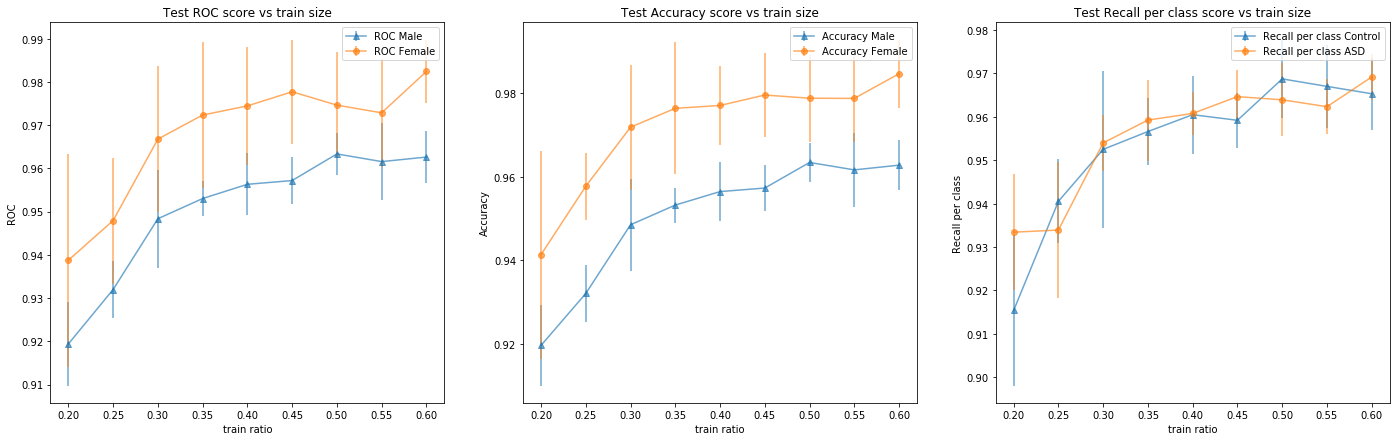

In [106]:
train_size = [1.0 - exp['test_size'] for exp in results]

plt.figure(figsize=(24, 7))

metric = "ROC"
mean_m_points = [exp['mean {} M/F test'.format(metric)][0] for exp in results]
std_m_points = [exp['std {} M/F test'.format(metric)][0] for exp in results]
mean_f_points = [exp['mean {} M/F test'.format(metric)][1] for exp in results]
std_f_points = [exp['std {} M/F test'.format(metric)][1] for exp in results]

plt.subplot(131)
plt.title("Test {} score vs train size".format(metric))
plt.errorbar(train_size, mean_m_points, std_roc_m_points, marker='^', alpha=0.65, label="{} Male".format(metric))
plt.errorbar(train_size, mean_f_points, std_roc_f_points, marker='o', alpha=0.65, label="{} Female".format(metric))
plt.xlabel("train ratio")
plt.ylabel(metric)
plt.legend()


metric = "Accuracy"
mean_m_points = [exp['mean {} M/F test'.format(metric)][0] for exp in results]
std_m_points = [exp['std {} M/F test'.format(metric)][0] for exp in results]
mean_f_points = [exp['mean {} M/F test'.format(metric)][1] for exp in results]
std_f_points = [exp['std {} M/F test'.format(metric)][1] for exp in results]

plt.subplot(132)
plt.title("Test {} score vs train size".format(metric))
plt.errorbar(train_size, mean_m_points, std_m_points, marker='^', alpha=0.65, label="{} Male".format(metric))
plt.errorbar(train_size, mean_f_points, std_f_points, marker='o', alpha=0.65, label="{} Female".format(metric))
plt.xlabel("train ratio")
plt.ylabel(metric)
plt.legend()

metric = "Recall per class"
mean_m_points = [exp['mean {} test'.format(metric)][0] for exp in results]
std_m_points = [exp['std {} test'.format(metric)][0] for exp in results]
mean_f_points = [exp['mean {} test'.format(metric)][1] for exp in results]
std_f_points = [exp['std {} test'.format(metric)][1] for exp in results]

plt.subplot(133)
plt.title("Test {} score vs train size".format(metric))
plt.errorbar(train_size, mean_m_points, std_m_points, marker='^', alpha=0.65, label="{} Control".format(metric))
plt.errorbar(train_size, mean_f_points, std_f_points, marker='o', alpha=0.65, label="{} ASD".format(metric))
plt.xlabel("train ratio")
plt.ylabel(metric)
plt.legend()


CV + small test : f2 + f3

In [176]:
np.bincount(labels_test_)

array([11, 12])

In [177]:
np.bincount(data_test_['anatomy_select'])

array([ 0, 21,  2])

In [178]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [179]:
seed = 12345

In [185]:
n_splits = 7
splt = StratifiedKFold(n_splits=n_splits, random_state=seed)

pipes = []
X_test = data_test_
y_test = labels_test_


for train_indices, test_indices in splt.split(data_train_, labels_train_):

    train_idx = data_train_.index[train_indices]
    test_idx = data_train_.index[test_indices]
    X_train = data_train_.loc[train_idx, :]
    y_train = labels_train_[train_indices]

    pipe = make_pipeline(FeatureExtractor(), Classifier())
    pipe.fit(X_train, y_train)
    pipes.append(pipe)

    X_valid = data_train_.loc[test_idx, :]
    y_valid = labels_train_[test_indices]
    y_valid_pred = pipe.predict(X_valid)
    print("ROC valid={}".format(roc_auc_score(y_valid, y_valid_pred)))
    
    
y_test_preds = np.zeros((len(y_test), n_splits))
for i, pipe in enumerate(pipes):
    y_test_preds[:, i] = pipe.predict_proba(X_test)[:, 1]


y_test_pred = (y_test_preds.mean(axis=1) > 0.5).astype(np.uint8)
print("ROC test={}".format(roc_auc_score(y_test, y_test_pred)))
print("Acc test={}".format(accuracy_score(y_test, y_test_pred)))
print("Recall test={}".format(recall_score(y_test, y_test_pred, average=None)))

ROC valid=0.9687547746371276
ROC valid=0.9192513368983958
ROC valid=0.9502164502164502
ROC valid=0.9296536796536795
ROC valid=0.9377705627705627
ROC valid=0.9235588972431078
ROC valid=0.9229323308270676
ROC test=0.606060606060606
Acc test=0.6086956521739131
Recall test=[0.54545455 0.66666667]


imbalanced
```
ROC valid=0.9687547746371276
ROC valid=0.9192513368983958
ROC valid=0.9502164502164502
ROC valid=0.9296536796536795
ROC valid=0.9377705627705627
ROC valid=0.9235588972431078
ROC valid=0.9229323308270676
ROC test=0.606060606060606
Acc test=0.6086956521739131
Recall test=[0.54545455 0.66666667]
```


balanced
```
ROC valid=0.9628724216959511
ROC valid=0.9192513368983958
ROC valid=0.9502164502164502
ROC valid=0.9296536796536795
ROC valid=0.9442640692640693
ROC valid=0.9301378446115287
ROC valid=0.9229323308270676
ROC test=0.5606060606060606
Acc test=0.5652173913043478
Recall test=[0.45454545 0.66666667]
```

CV + small test : f1

In [12]:
np.bincount(labels_test_)

array([11, 12])

In [13]:
np.bincount(data_test_['anatomy_select'])

array([ 0, 21,  2])

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score

In [21]:
seed = 12345

In [22]:
n_splits = 7
splt = StratifiedKFold(n_splits=n_splits, random_state=seed)

pipes = []
X_test = data_test_
y_test = labels_test_


for train_indices, test_indices in splt.split(data_train_, labels_train_):

    train_idx = data_train_.index[train_indices]
    test_idx = data_train_.index[test_indices]
    X_train = data_train_.loc[train_idx, :]
    y_train = labels_train_[train_indices]

    pipe = make_pipeline(FeatureExtractor(), Classifier())
    pipe.fit(X_train, y_train)
    pipes.append(pipe)

    X_valid = data_train_.loc[test_idx, :]
    y_valid = labels_train_[test_indices]
    y_valid_pred = pipe.predict(X_valid)
    print("ROC valid={}".format(roc_auc_score(y_valid, y_valid_pred)))
    
    
y_test_preds = np.zeros((len(y_test), n_splits))
for i, pipe in enumerate(pipes):
    y_test_preds[:, i] = pipe.predict_proba(X_test)[:, 1]


y_test_pred = (y_test_preds.mean(axis=1) > 0.5).astype(np.uint8)
print("ROC test={}".format(roc_auc_score(y_test, y_test_pred)))
print("Acc test={}".format(accuracy_score(y_test, y_test_pred)))
print("Recall test={}".format(recall_score(y_test, y_test_pred, average=None)))

ROC valid=0.6934300993124523
ROC valid=0.7122994652406417
ROC valid=0.637987012987013
ROC valid=0.6363636363636364
ROC valid=0.7429653679653679
ROC valid=0.6353383458646616
ROC valid=0.6090225563909775
ROC test=0.5795454545454545
Acc test=0.5652173913043478
Recall test=[0.90909091 0.25      ]


f1
imbalanced
```
ROC valid=0.6934300993124523
ROC valid=0.7122994652406417
ROC valid=0.637987012987013
ROC valid=0.6363636363636364
ROC valid=0.7429653679653679
ROC valid=0.6353383458646616
ROC valid=0.6090225563909775
ROC test=0.5795454545454545
Acc test=0.5652173913043478
Recall test=[0.90909091 0.25
```

In [23]:
gender = X_test['participants_sex'].values
age = X_test['participants_age'].values

for i in range(len(y_test)):
    print(i, " : ", gender[i], age[i], y_test[i], " = ", "{:.3f}".format(y_test_preds[i, :].mean()), 
        " <- ", ["{:.3f}".format(v) for v in y_test_preds[i, :]])
    

0  :  M 12.2 0  =  0.051  <-  ['0.037', '0.050', '0.044', '0.083', '0.049', '0.024', '0.072']
1  :  M 14.0 1  =  0.514  <-  ['0.487', '0.552', '0.415', '0.582', '0.420', '0.591', '0.553']
2  :  M 14.425 0  =  0.667  <-  ['0.744', '0.659', '0.608', '0.609', '0.687', '0.699', '0.664']
3  :  M 22.8802 1  =  0.593  <-  ['0.594', '0.604', '0.602', '0.584', '0.551', '0.630', '0.583']
4  :  M 8.252054795 1  =  0.275  <-  ['0.266', '0.276', '0.262', '0.334', '0.248', '0.257', '0.279']
5  :  M 18.2177 0  =  0.492  <-  ['0.445', '0.432', '0.375', '0.553', '0.512', '0.628', '0.498']
6  :  M 17.93 1  =  0.362  <-  ['0.353', '0.406', '0.227', '0.352', '0.345', '0.436', '0.414']
7  :  M 22.99 1  =  0.452  <-  ['0.572', '0.465', '0.443', '0.333', '0.427', '0.367', '0.555']
8  :  M 14.3 1  =  0.859  <-  ['0.833', '0.859', '0.932', '0.829', '0.793', '0.869', '0.896']
9  :  M 29.0 1  =  0.458  <-  ['0.476', '0.551', '0.441', '0.577', '0.306', '0.424', '0.433']
10  :  M 14.1 1  =  0.376  <-  ['0.493', '0

Best features exploration

In [165]:
cols = [c for c in f1_columns if "Amygdala" in c]
cols

['(anatomy_Left-Amygdala - anatomy_Right-Amygdala)']

In [163]:
cols = [c for c in f2_columns if "Amygdala" in c and "age" in c]
cols

['(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_age']

In [162]:
cols = [c for c in f3_columns if "Amygdala" in c and "age" in c]
cols

['(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_age x anatomy_CC_Posterior',
 '(anatomy_Left-Amygdala - anatomy_Right-Amygdala) / participants_age x anatomy_4th-Ventricle']

In [166]:
cols = [c for c in f3_columns if "Cerebellum" in c and "age" in c]
cols

['(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_age x anatomy_Brain-Stem',
 '(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_age x anatomy_Optic-Chiasm',
 '(anatomy_Left-Cerebellum-White-Matter + anatomy_Right-Cerebellum-White-Matter) x participants_age x anatomy_CC_Anterior']